# Optimized KF and Neural KF

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB
import ScenarioSimulator as ssim

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Configurate scenarios & models

#### Scenarios

In [3]:
nms_map = dict(cart_iso_cent='Toy',centered='Close',const_speed='Const_v',acceleration='Const_a',multiphase='Free')
scenarios_meta_args = {nms_map[k]:v for k,v in ssim.SCENARIOS_META_ARGS.items() if k!='multiacc'}

ax = ssim.show_meta_args_summary(scenarios_meta_args, utils.Axes(1,1,(2.8,3.2))[0],
                                 cols=['anisotropic', 'polar', 'uncentered', 'acceleration', 'turns']);
plt.tight_layout();
plt.savefig('outputs/benchmarks')

Benchmarks (rows) and their properties (columns): anisotropic -- horizontal motion is more likely; polar -- Radar noise is generated in polar coordinates; uncentered -- targets are not forced to concentrate close to the Radar; acceleration -- speed change allowed; turns -- non-straight motion allowed. Green means that the benchmark satisfies the property.

**Basic scenarios properties:**
- **varying_H**: the observation operator $H$ depends on target position.
- **anisotropic**: horizontal motion is more likely than vertical.
- **polar**: Radar detection noise is defined in polar coordinates (as in a real Radar system).
- **uncentered**: targets trajectories are not necessarily concentrated close to the location of the Radar.
- **acceleration**: target speed is not necessarily constant.
- **turns**: motion is not necessarily straight.

**Models** (estimated/optimized params; extended/standard KF; polar/cartesian representation of $R$):

In [4]:
models_args = (
    dict(load=False, title='KF', no_acc=True),
    dict(load=False, title='OKF', no_acc=True, const_Q=False, const_R=False),
    dict(load=False, title='KFp', no_acc=True, polar_R=True),
    dict(load=False, title='OKFp', no_acc=True, const_Q=False, const_R=False, polar_R=True),
    dict(load=False, title='EKF', no_acc=True, EKF=True),
    dict(load=False, title='OEKF', no_acc=True, const_Q=False, const_R=False, EKF=True),
    dict(load=False, title='EKFp', no_acc=True, EKF=True, polar_R=True),
    dict(load=False, title='OEKFp', no_acc=True, const_Q=False, const_R=False, polar_R=True, EKF=True),
)

model_names = [a['title'] for a in models_args]

gc.collect()

20

# Generate scenarios


Toy
1500 1500 (42, 4) (42, 6) 13.0 65.0 Counter({'00<acc<00': 1500})
{'max_acc': 0, 'time': 24.0}
   phase      mode  time  acc   direct  angle
0      0  straight    25  0.0  forward      0

Close
1500 1500 (42, 4) (42, 6) 13.0 65.0 Counter({'00<acc<00': 1500})
{'max_acc': 0, 'time': 24.0}
   phase      mode  time  acc   direct  angle
0      0  straight    25  0.0  forward      0

Const_v
1500 1500 (39, 4) (39, 6) 11.0 86.0 Counter({'00<acc<00': 1500})
{'max_acc': 0, 'time': 24.0}
   phase      mode  time  acc   direct  angle
0      0  straight    25  0.0  forward      0

Const_a
1500 1500 (39, 4) (39, 6) 11.0 86.0 Counter({'08<acc<16': 1500})
{'max_acc': 16, 'time': 24.0}
   phase      mode  time       acc   direct  angle
0      0  straight    25  9.503853  forward      0

Free
1500 1500 (29, 4) (29, 6) 14.0 175.0 Counter({'16<acc<32': 1500})
{'max_acc': 32, 'time': 27.0}
   phase      mode  time        acc   direct      angle
0      0  straight    10  19.681531  forward   0.000000
1

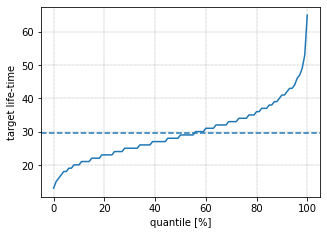

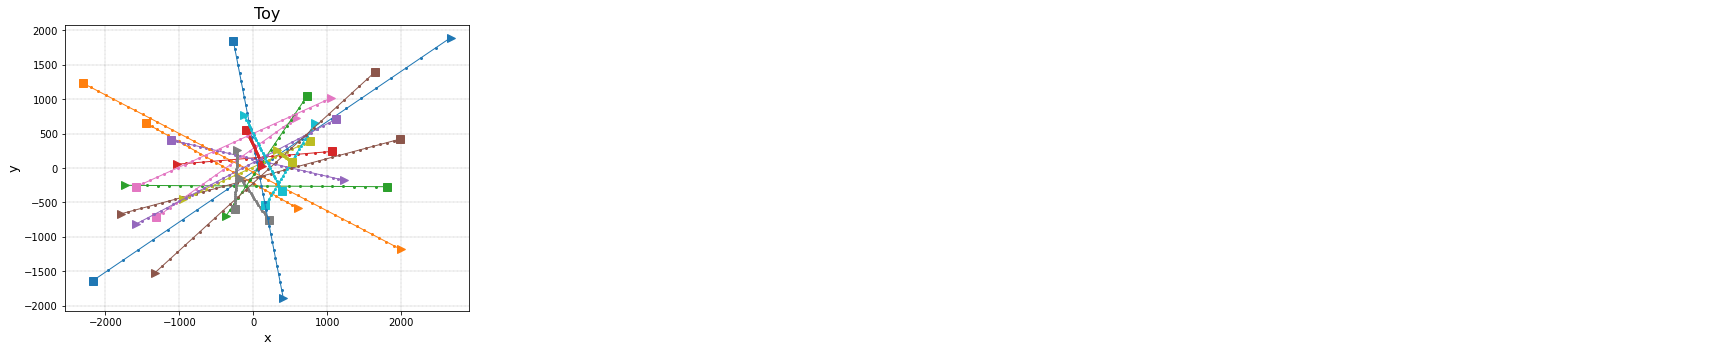

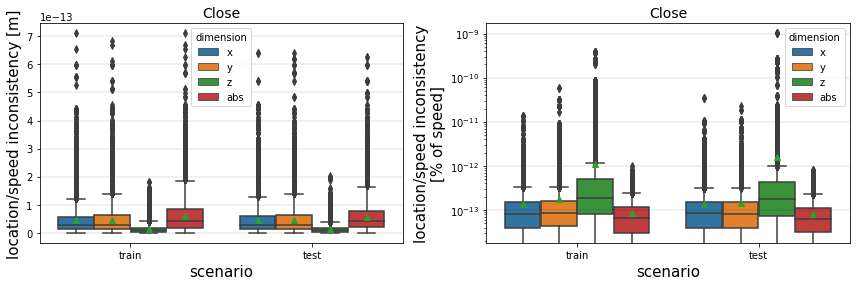

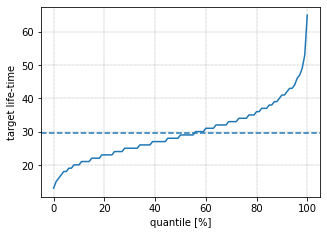

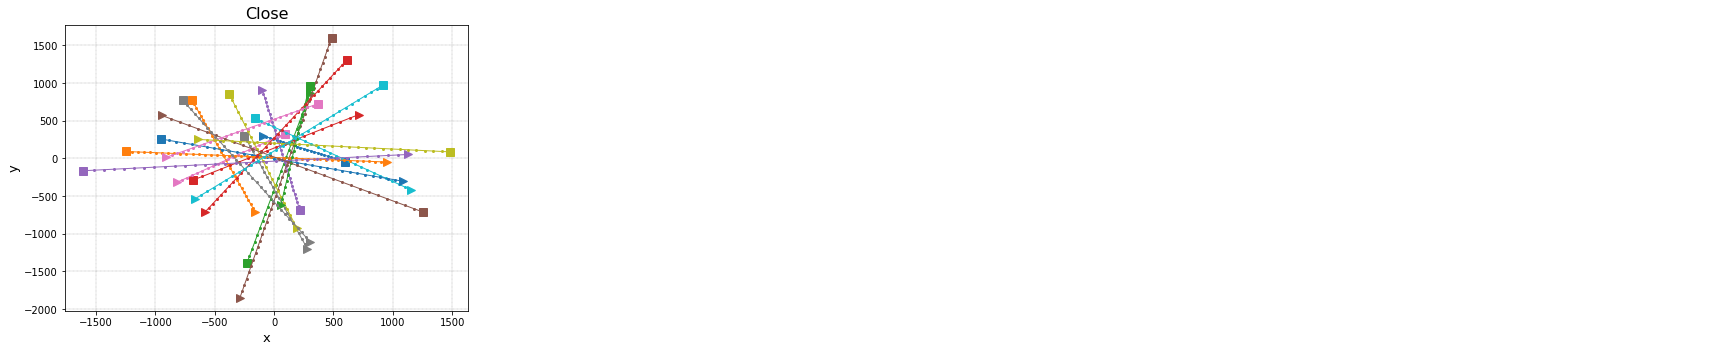

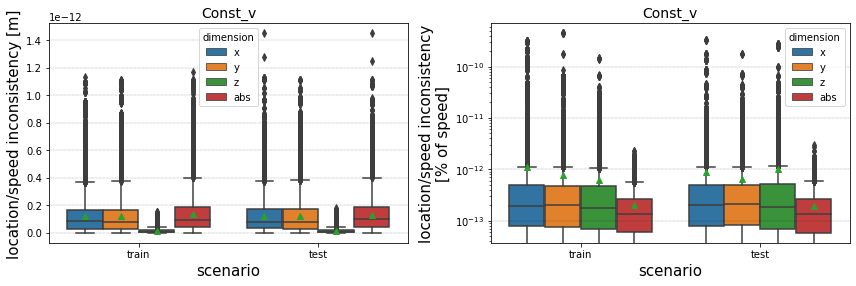

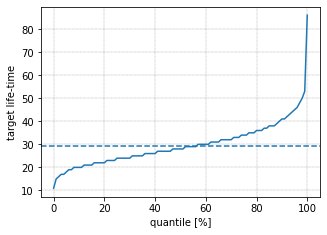

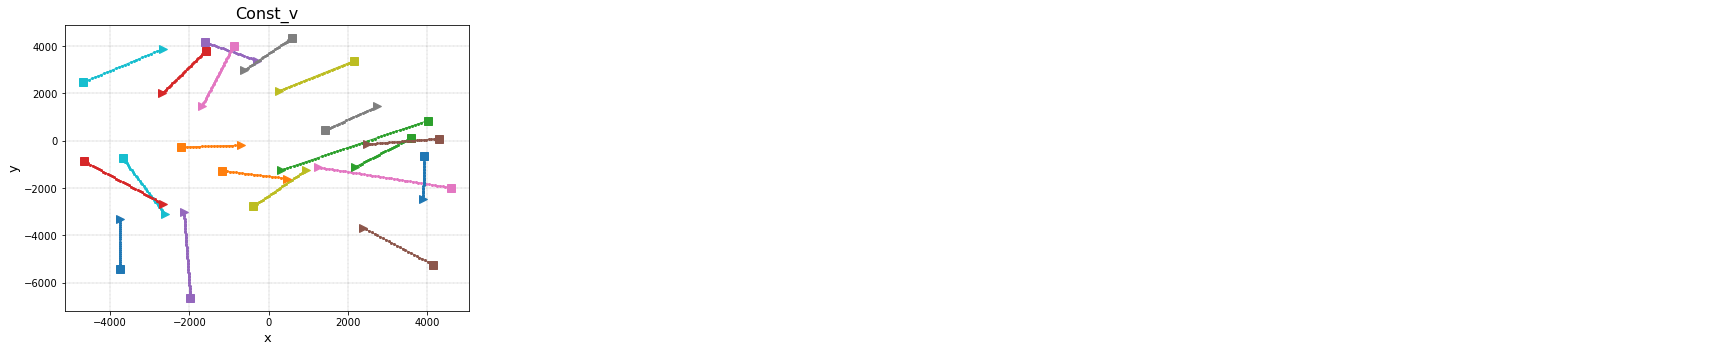

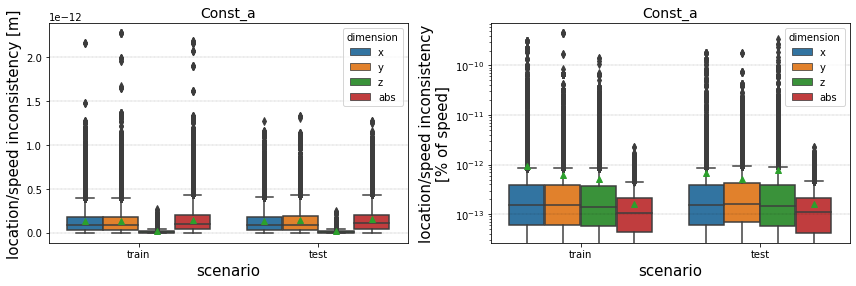

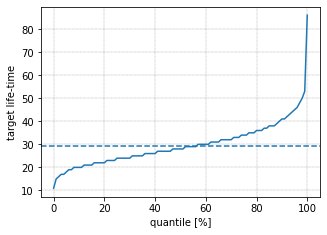

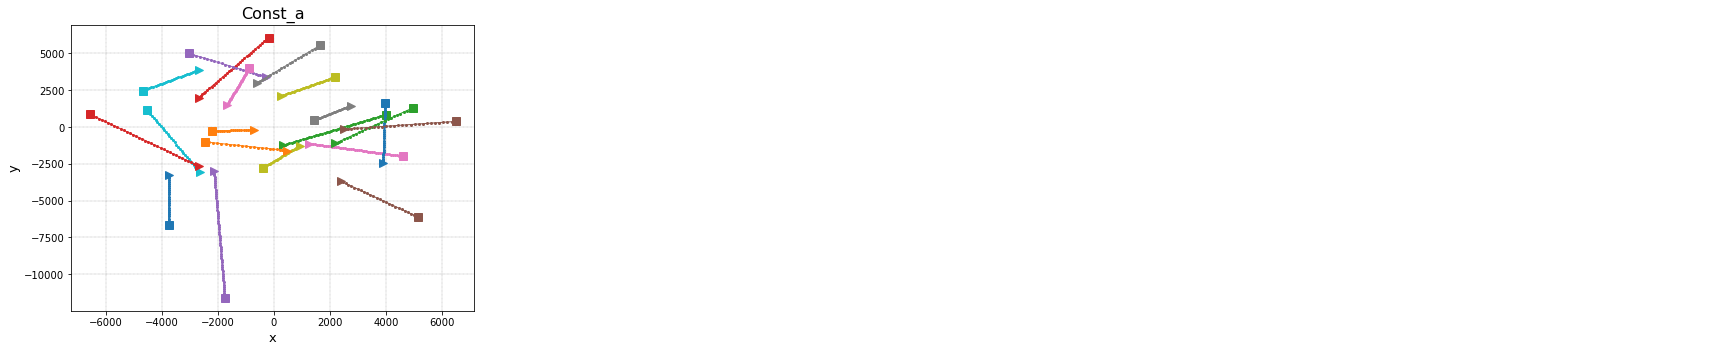

In [5]:
# Set GENERATE=False to load existing scenarios, or GENERATE=True to create new ones.
GENERATE = False
%time scenarios_args = ssim.generate_scenarios(meta_args=scenarios_meta_args, load=not GENERATE)

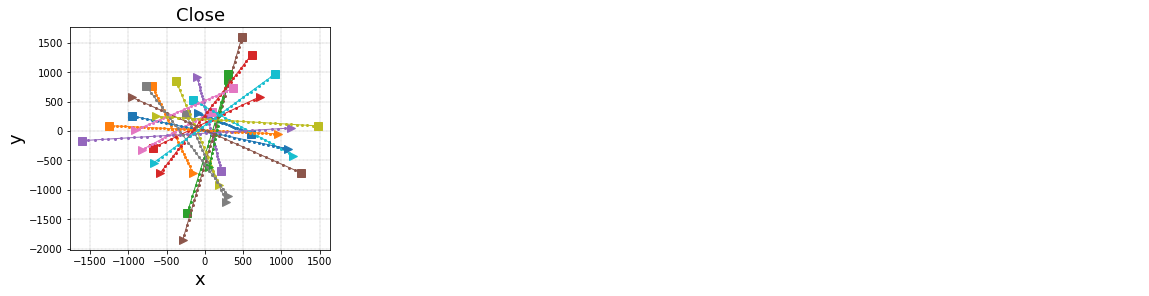

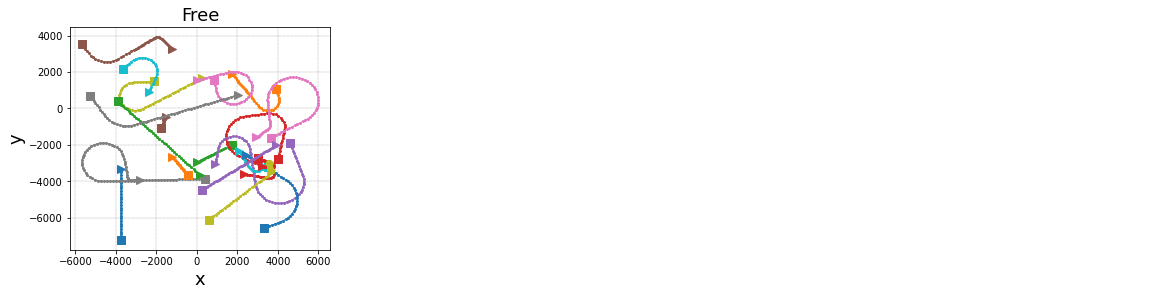

In [6]:
for title in scenarios_args:
    E = PLAB.create_experiment(title=title, load=True)
    axs = E.show_episodes(scenarios=['test'], episodes_per_scenario=1, max_targets=24, detailed_lab=False, axs_args=dict(axsize=(4,4.5)))
    axs[0][0].get_legend().remove()
    #axs[0][0].set_title(title, fontsize=18)
    utils.labels(axs[0][0], 'x', 'y', title, fontsize=18)
    plt.savefig(f'outputs/tars_{title}')

#### Some properties of the scenarios

In [7]:
%time axs, dd, dd_tar = ssim.summarize_scenarios(list(scenarios_args.keys()))
plt.savefig('outputs/benchmarks_EDA.png', bbox_inches='tight')

CPU times: user 3.45 s, sys: 167 ms, total: 3.62 s
Wall time: 3.09 s


# Train & test

For each scenario: for each model: train the model on the scenario's train data, then test it on the test data of the same scenario.


Toy
Waiting for trainings...
Waiting for processes...
Done.	(267 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 88 (OKF_s00)
	KFp: inf (KFp_s00)
	OKFp: 120 (OKFp_s00)
	EKF: inf (EKF_s00)
	OEKF: 84 (OEKF_s00)
	EKFp: inf (EKFp_s00)
	OEKFp: 111 (OEKFp_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))


8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(22 [s])


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])



Close
Waiting for trainings...
Waiting for processes...
Done.	(272 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 27 (OKF_s00)
	KFp: inf (KFp_s00)
	OKFp: 25 (OKFp_s00)
	EKF: inf (EKF_s00)
	OEKF: 28 (OEKF_s00)
	EKFp: inf (EKFp_s00)
	OEKFp: 26 (OEKFp_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))


8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(23 [s])


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])



Const_v
Waiting for trainings...
Waiting for processes...
Done.	(263 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 95 (OKF_s00)
	KFp: inf (KFp_s00)
	OKFp: 94 (OKFp_s00)
	EKF: inf (EKF_s00)
	OEKF: 103 (OEKF_s00)
	EKFp: inf (EKFp_s00)
	OEKFp: 104 (OEKFp_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))


8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(23 [s])


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])



Const_a
Waiting for trainings...
Waiting for processes...
Done.	(271 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 103 (OKF_s00)
	KFp: inf (KFp_s00)
	OKFp: 102 (OKFp_s00)
	EKF: inf (EKF_s00)
	OEKF: 109 (OEKF_s00)
	EKFp: inf (EKFp_s00)
	OEKFp: 110 (OEKFp_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))


8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(22 [s])


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])



Free
Waiting for trainings...
Waiting for processes...
Done.	(490 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 121 (OKF_s00)
	KFp: inf (KFp_s00)
	OKFp: 119 (OKFp_s00)
	EKF: inf (EKF_s00)
	OEKF: 125 (OEKF_s00)
	EKFp: inf (EKFp_s00)
	OEKFp: 123 (OEKFp_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))


8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(41 [s])


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


CPU times: user 1min 58s, sys: 17 s, total: 2min 15s
Wall time: 30min 5s


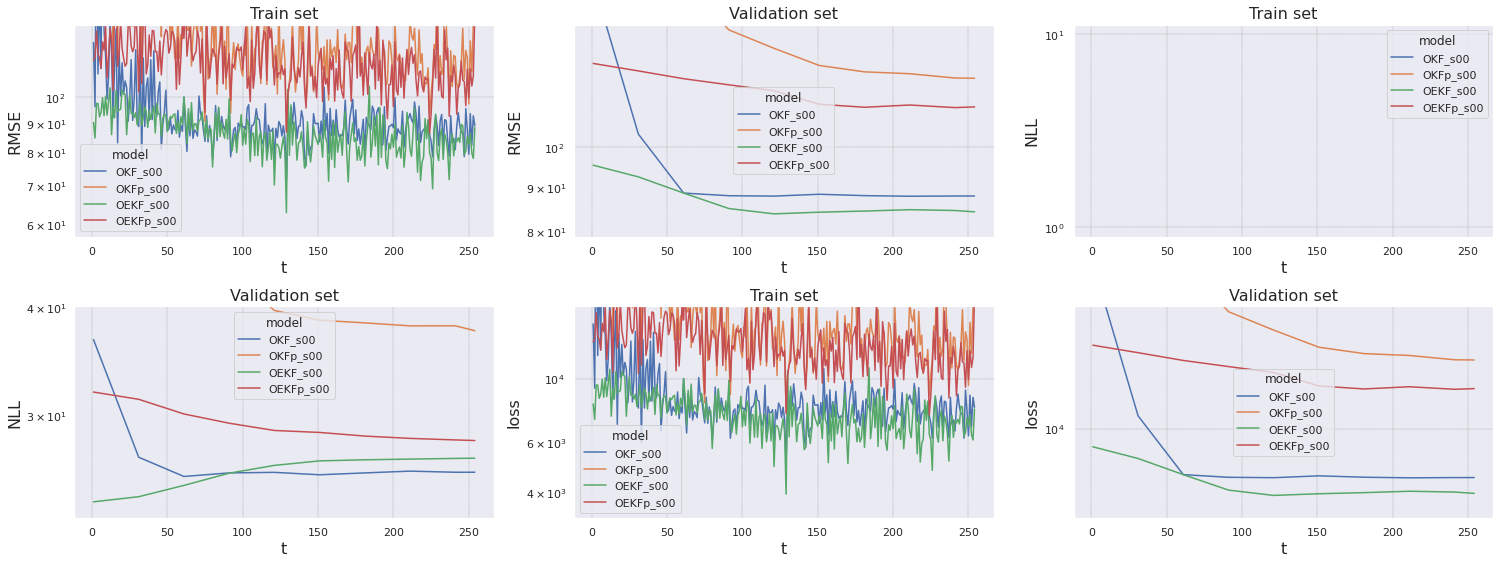

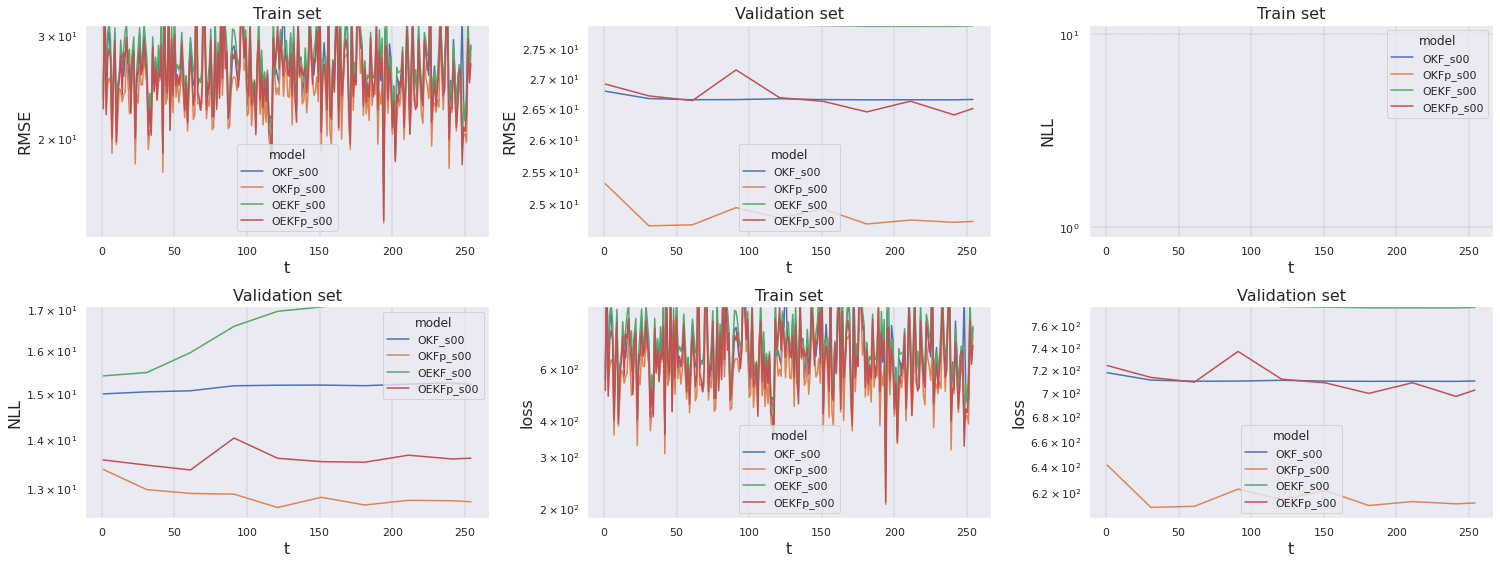

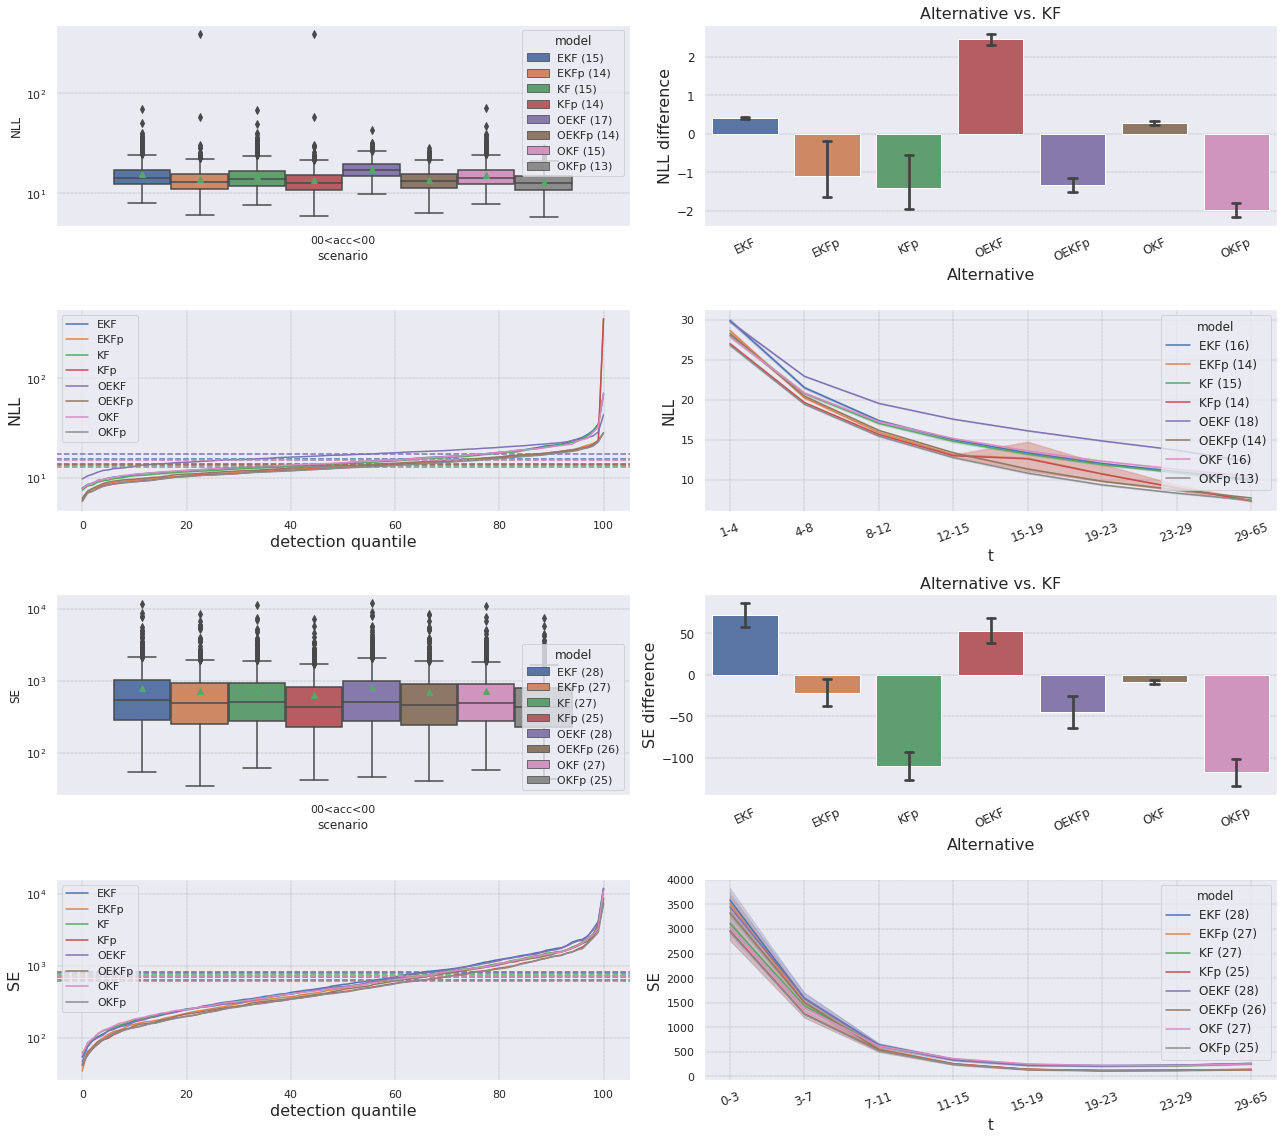

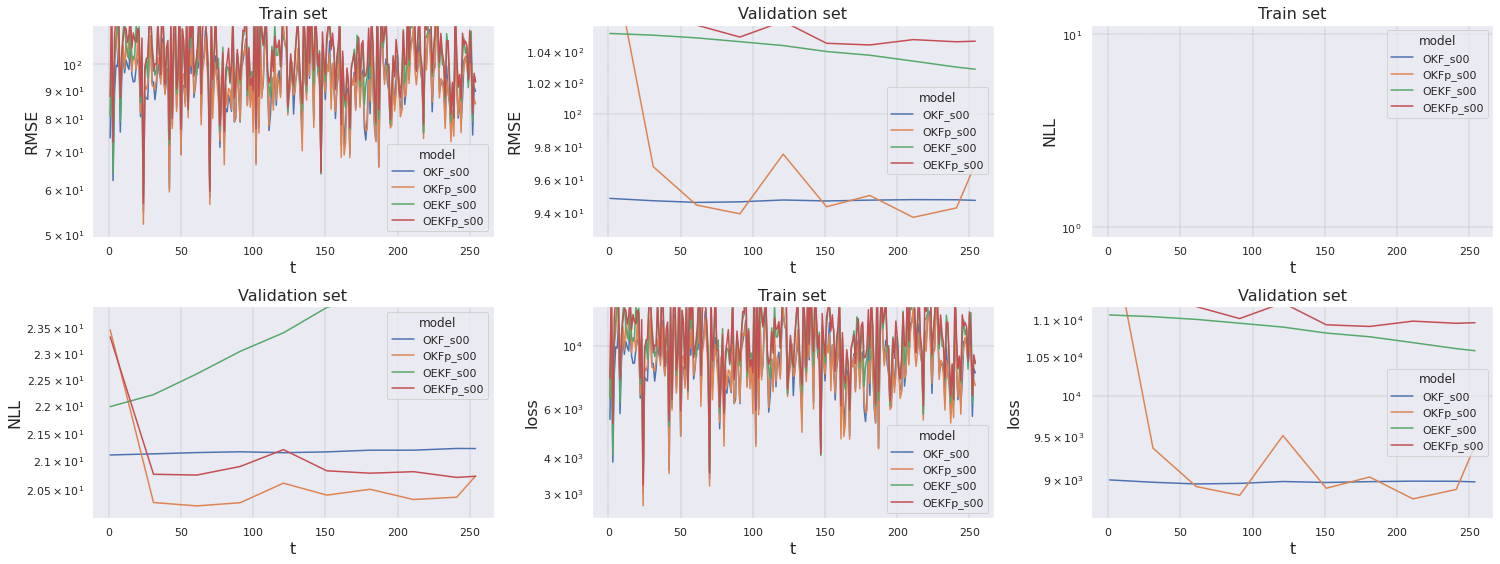

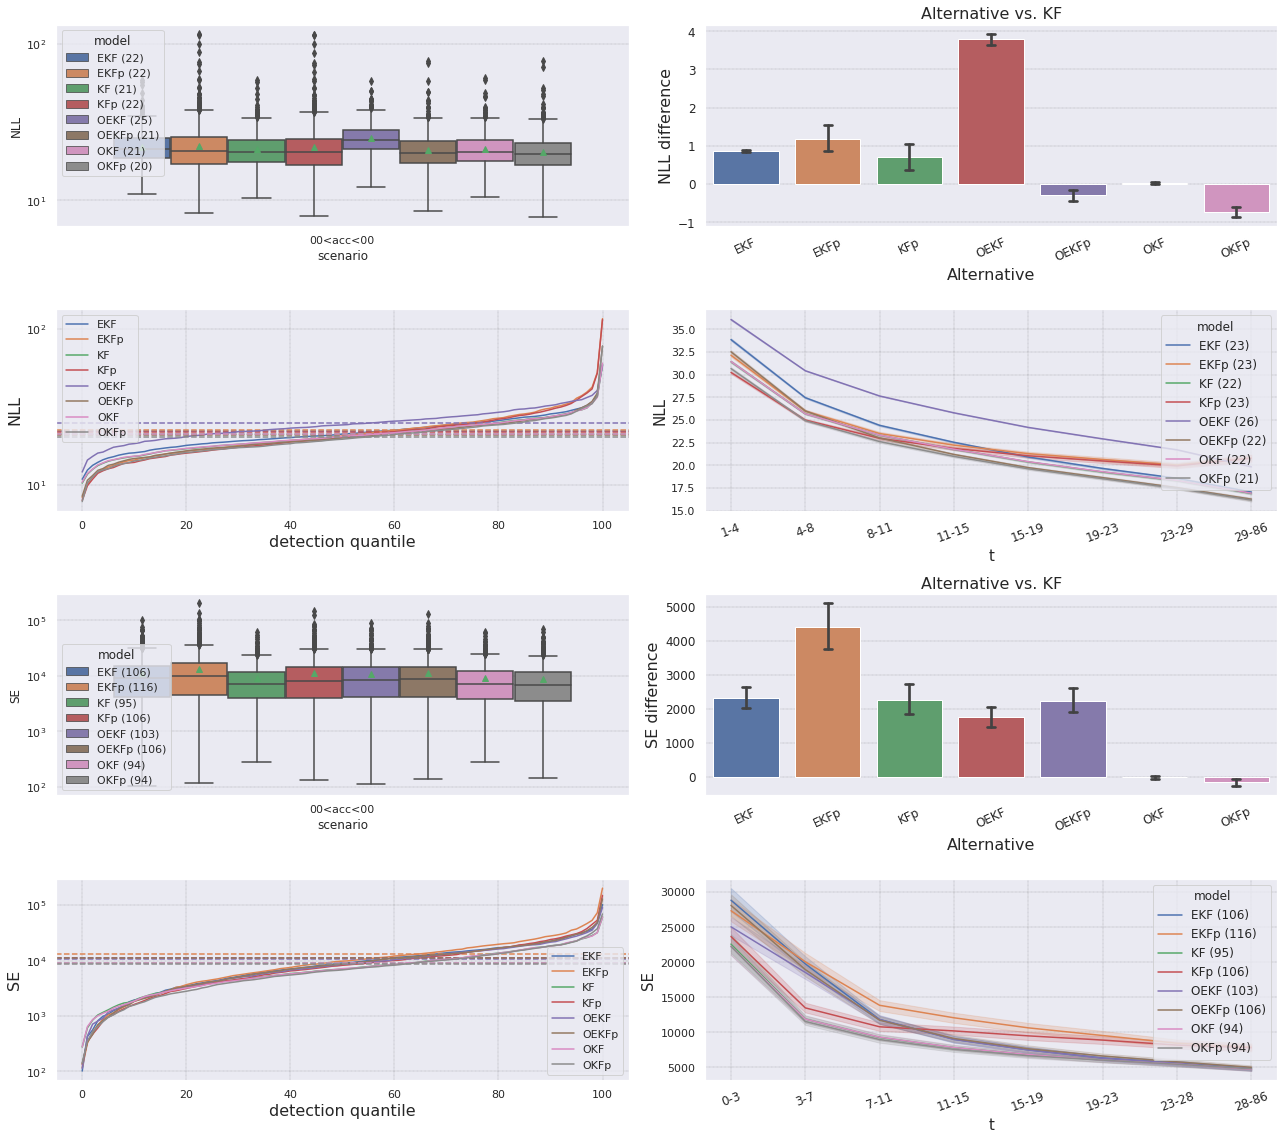

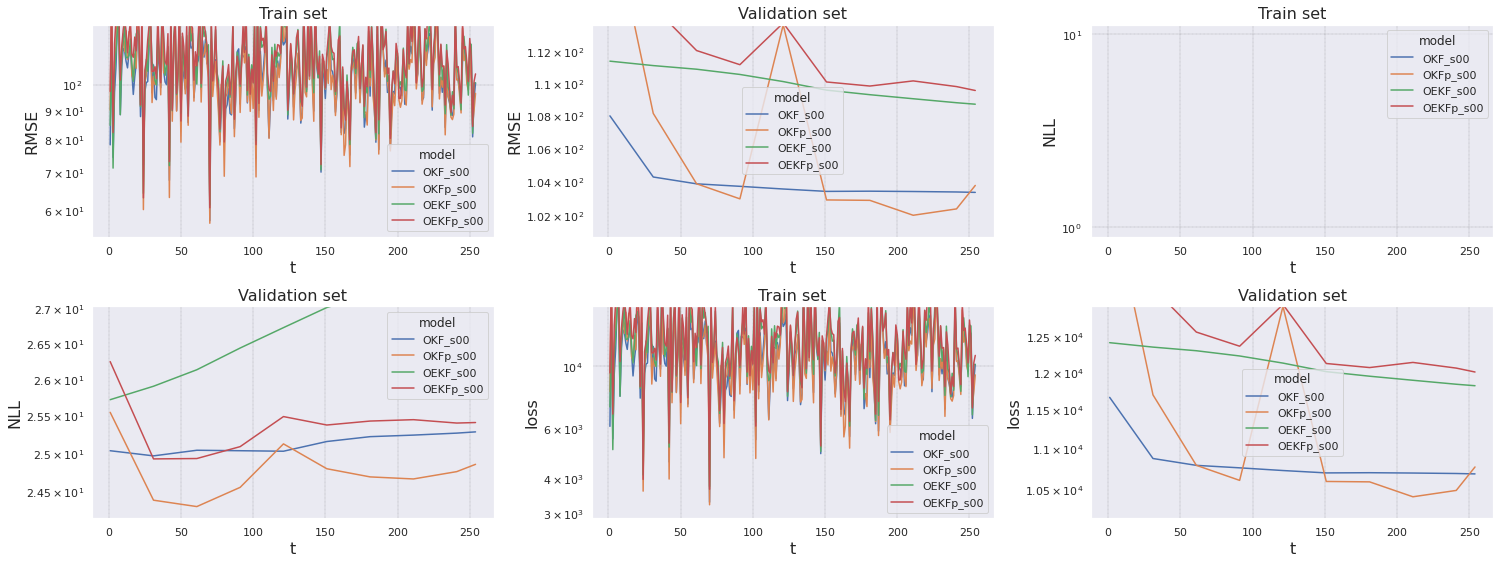

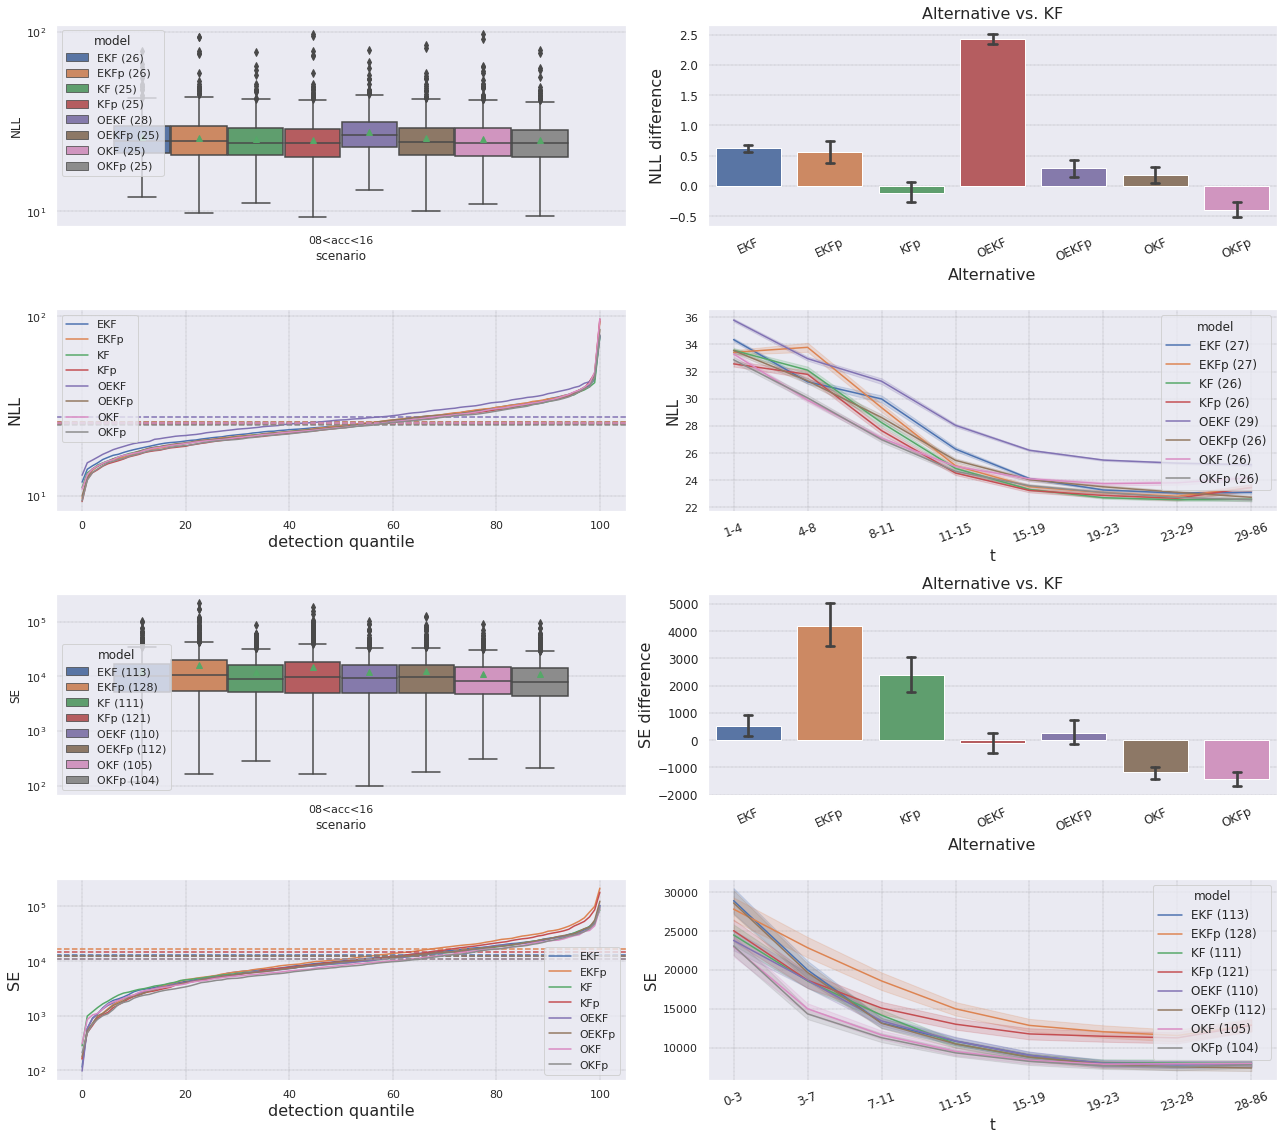

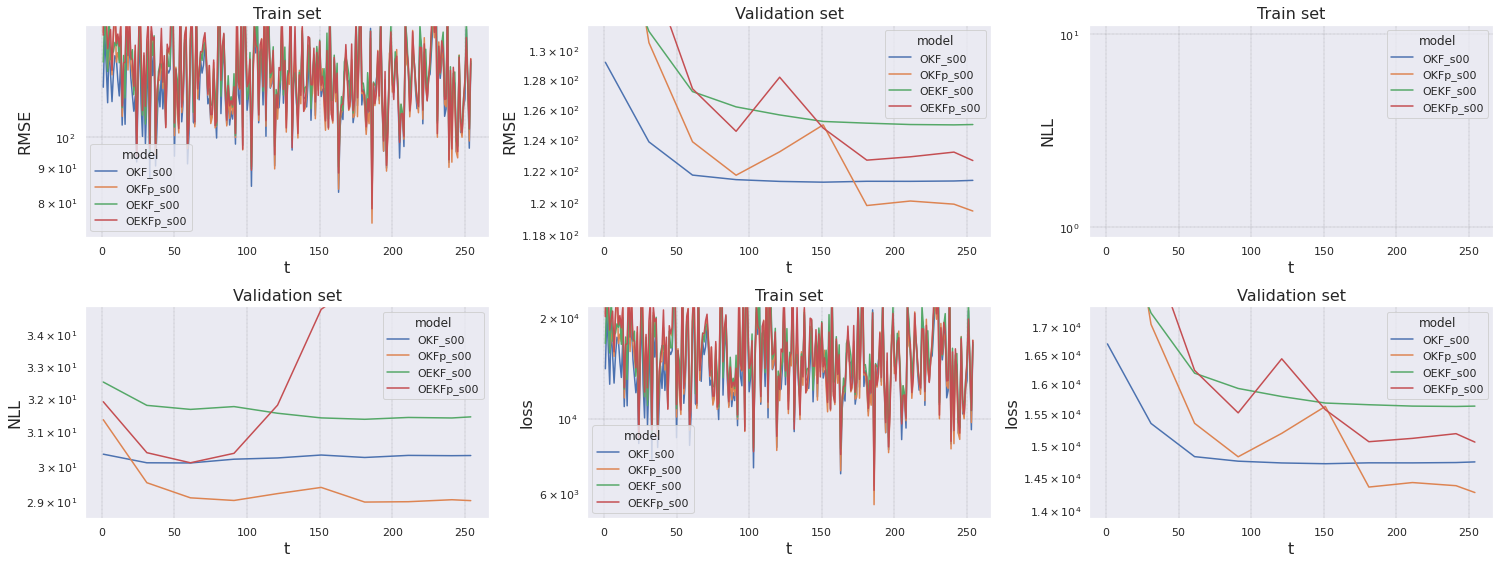

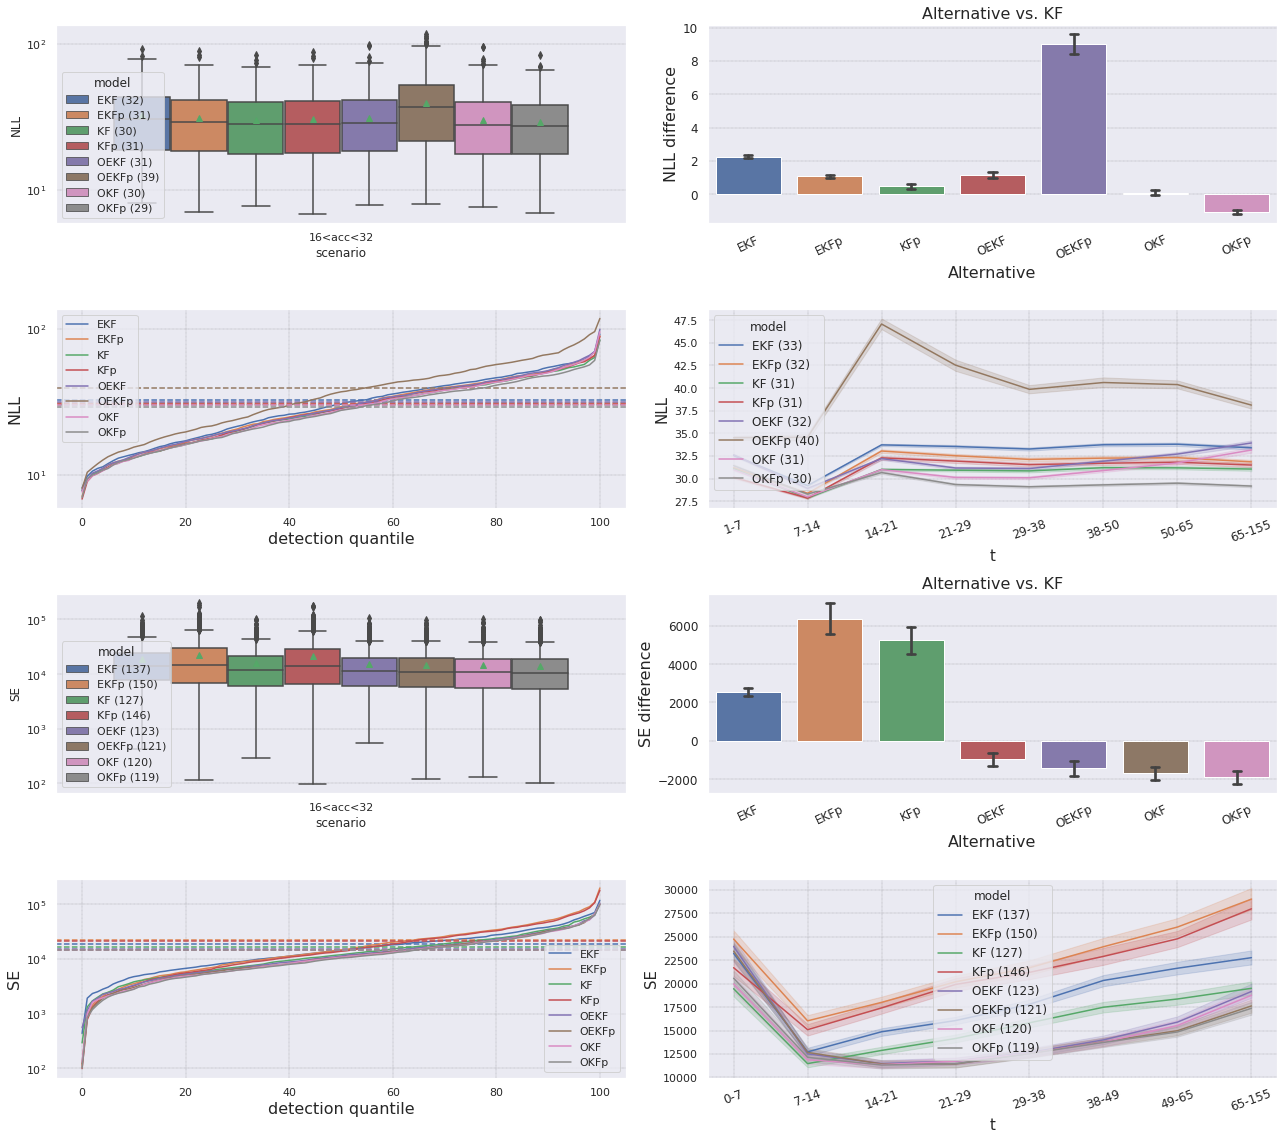

In [13]:
%%time
DO_TRAIN = True # use False to only load models
scenarios = list(scenarios_args.keys())
res = PLAB.multi_scenario_test(scenarios, models_args, epochs=2, do_train=DO_TRAIN)

In [14]:
res

model scenario  target   t  predicted_gaussian  matched_gaussian  \
0          KF      Toy       0   0                   0                 0   
1          KF      Toy       0   1                   0                 0   
2          KF      Toy       0   2                   0                 0   
3          KF      Toy       0   3                   0                 0   
4          KF      Toy       0   4                   0                 0   
...       ...      ...     ...  ..                 ...               ...   
449371  OEKFp     Free     990  39                   0                 0   
449372  OEKFp     Free     990  40                   0                 0   
449373  OEKFp     Free     990  41                   0                 0   
449374  OEKFp     Free     990  42                   0                 0   
449375  OEKFp     Free     990  43                   0                 0   

              NLL            SE          AE          loss  tar_class  
0        0.000000   3304.538466   57.485115   3304.538466  00<acc<00  
1       35.673796   4592.003723   67.764325   4592.003723  00<acc<00  
2       30.141762  18698.214642  136.741415  18698.214642  00<acc<00  
3       29.399480   7499.555773   86.599976   7499.555773  00<acc<00  
4       27.879694   1467.229642   38.304434   1467.229642  00<acc<00  
...           ...           ...         ...           ...        ...  
449371  89.387720   2357.518560   48.554285   2357.518560  16<acc<32  
449372  44.421870   1729.532484   41.587648   1729.532484  16<acc<32  
449373  28.327108   7836.700148   88.525139   7836.700148  16<acc<32  
449374  25.726478   1719.932871   41.472073   1719.932871  16<acc<32  
449375  23.729327   3029.571013   55.041539   3029.571013  16<acc<32  

[1413344 rows x 11 columns]

Aggregate results per target:

In [15]:
res_tar = PLAB.res_per_target(res, ['model','scenario'])
res_tar

scenario  target model  wt        NLL            SE  \
target model scenario                                                         
0      EKF   Close    0    Close       0   EKF  33  12.124902    345.873773   
             Const_a  0  Const_a       0   EKF  34  25.927101   3324.968953   
             Const_v  0  Const_v       0   EKF  34  18.292217    797.182548   
             Free     0     Free       0   EKF  92  81.124106  22271.779754   
             Toy      0      Toy       0   EKF  33  21.660340   8385.928140   
...                          ...     ...   ...  ..        ...           ...   
990    OKFp  Close    0    Close     990  OKFp  52  15.439960    947.357095   
             Const_a  0  Const_a     990  OKFp  22  18.897929  16045.142148   
             Const_v  0  Const_v     990  OKFp  22  12.910745   7946.810138   
             Free     0     Free     990  OKFp  44  39.778582  11334.484985   
             Toy      0      Toy     990  OKFp  52  93.476578  37307.578245   

                                 AE          loss  tar_class  
target model scenario                                         
0      EKF   Close    0   13.960583    373.695549  00<acc<00  
             Const_a  0   53.281417   3486.766872  08<acc<16  
             Const_v  0   20.879047    835.974633  00<acc<00  
             Free     0  209.095036   8631.401715  16<acc<32  
             Toy      0   77.201392   9060.484681  00<acc<00  
...                             ...           ...        ...  
990    OKFp  Close    0   23.106037    649.567971  00<acc<00  
             Const_a  0   66.767936  26003.698496  08<acc<16  
             Const_v  0   59.384332  12879.066631  00<acc<00  
             Free     0  107.168632   9184.665596  16<acc<32  
             Toy      0  216.213367  25580.436364  00<acc<00  

[39640 rows x 9 columns]

# Results analysis

#### Summary of results:

Estimated KFs:

In [16]:
# axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios, models=('KF','KFp','EKF','EKFp'), axsize=(4,3.5));

Optimized KFs:

In [17]:
# axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios, models=('OKF','OKFp','OEKF','OEKFp'), axsize=(4,3.5));

All KFs:

In [18]:
# %time axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios, models=('KF','OKF','KFp','OKFp','EKF','OEKF','EKFp','OEKFp'));

CPU times: user 11.2 s, sys: 391 ms, total: 11.6 s
Wall time: 11.2 s


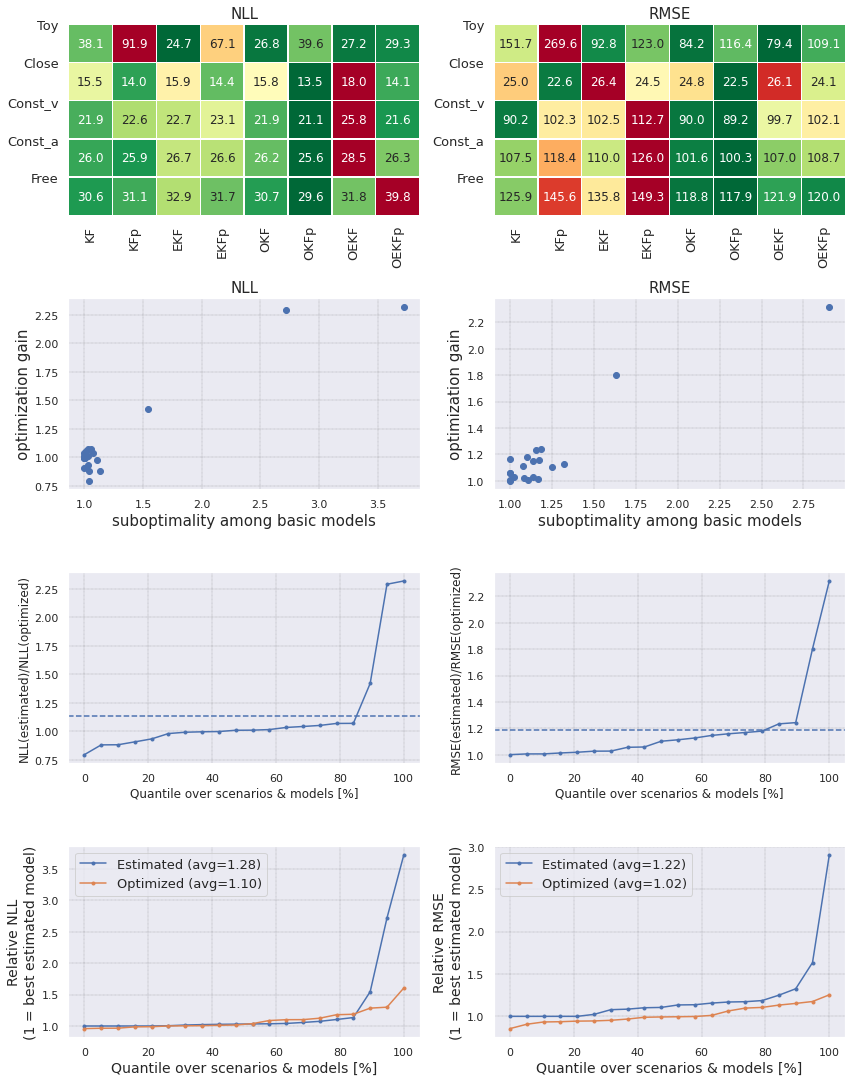

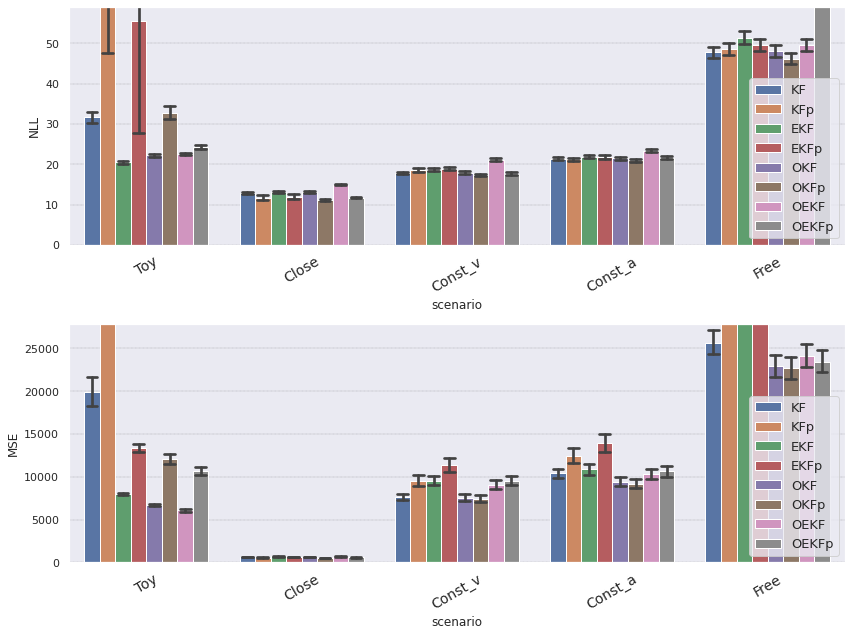

In [19]:
%time axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios, models=('KF','KFp','EKF','EKFp','OKF','OKFp','OEKF','OEKFp'), savefig='case_study_res'); # dpi?

#### KF vs. OKF on a sample of targets

XY plane:

In [20]:
margs = [m for m in models_args if m['title'] in ('KF','OKF')]

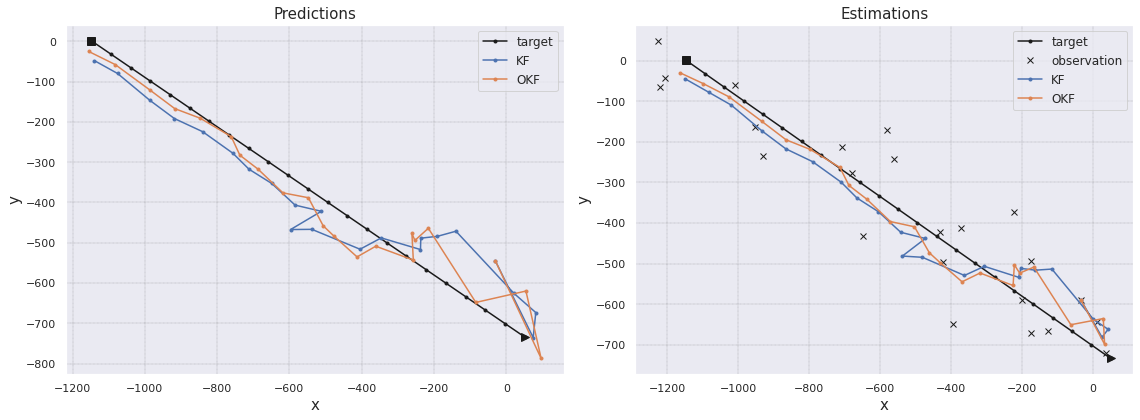

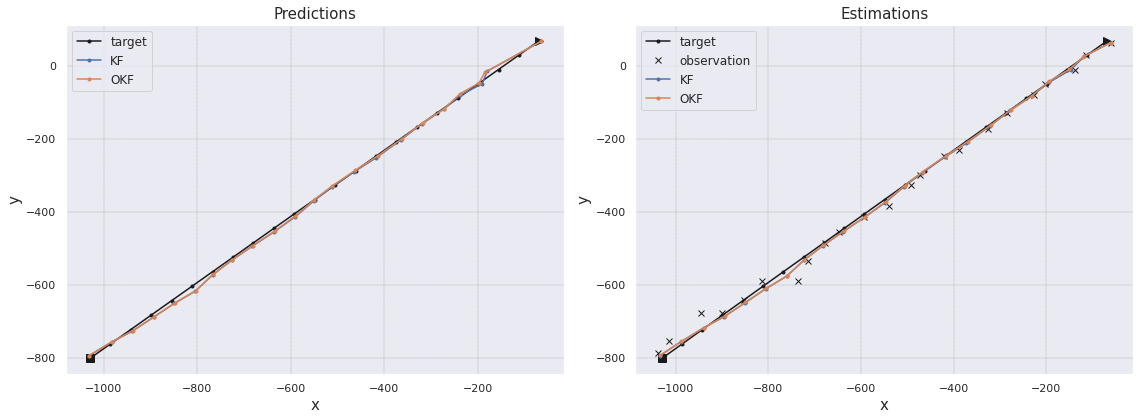

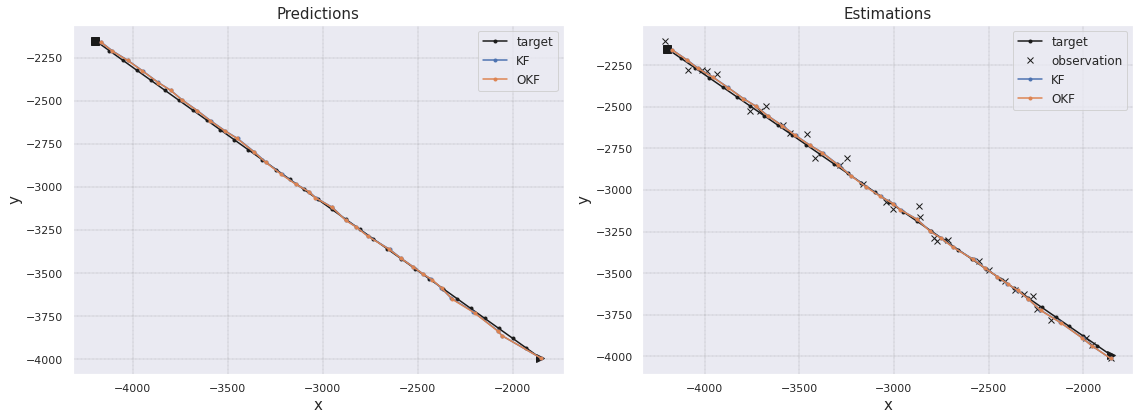

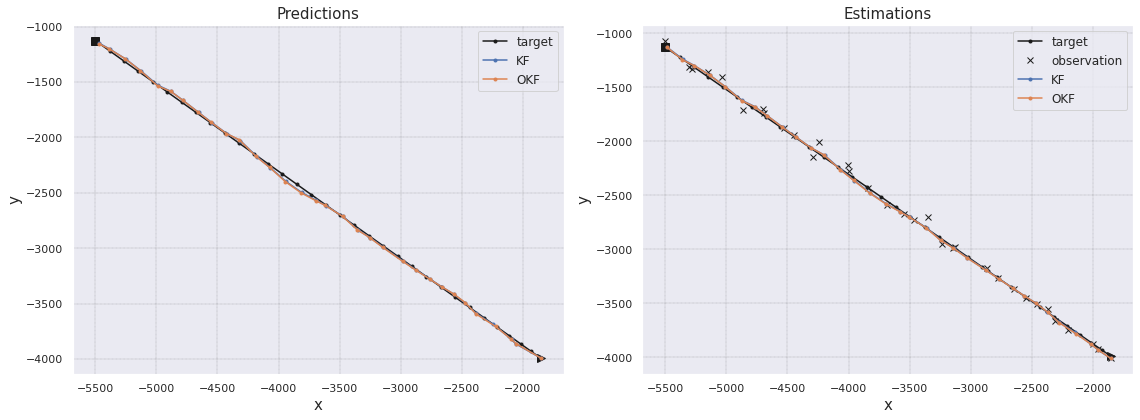

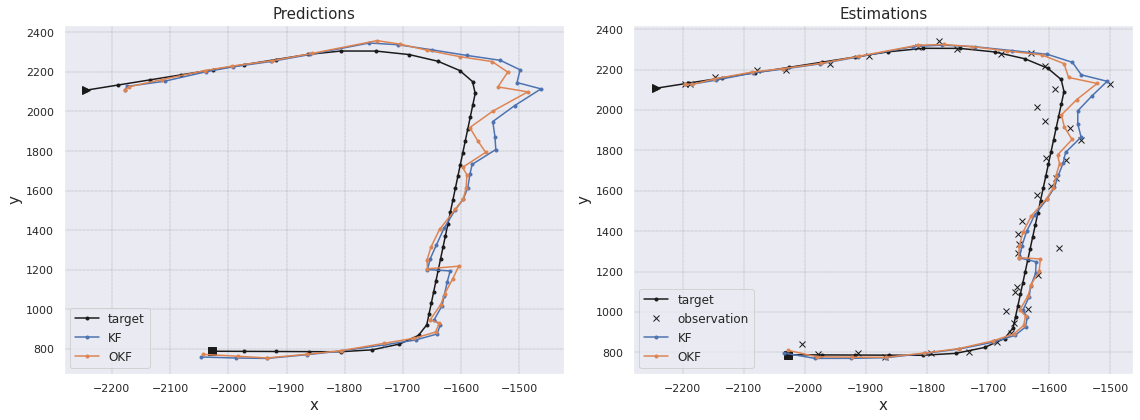

In [21]:
axs = PLAB.multi_scenario_models_plot(scenarios, margs, 1);
# axs[-1][0].set_xlim((-2000,-1500))
# axs[-1][1].set_xlim((-2000,-1500))
# axs[-1][0].set_ylim((-2400,-1800))
# axs[-1][1].set_ylim((-2400,-1800))

XZ plane:

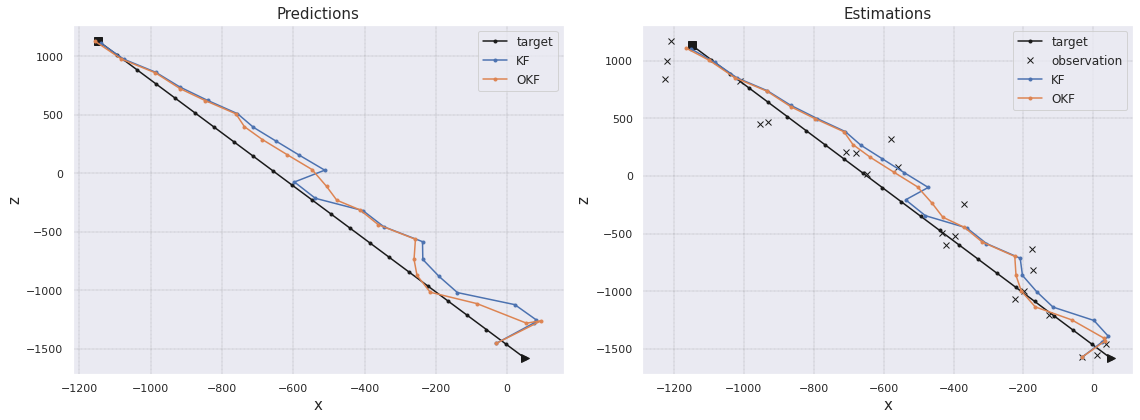

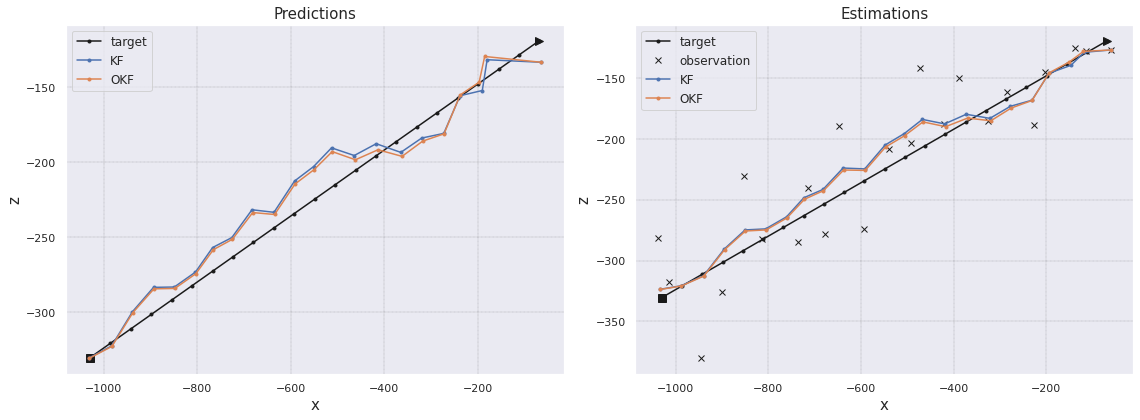

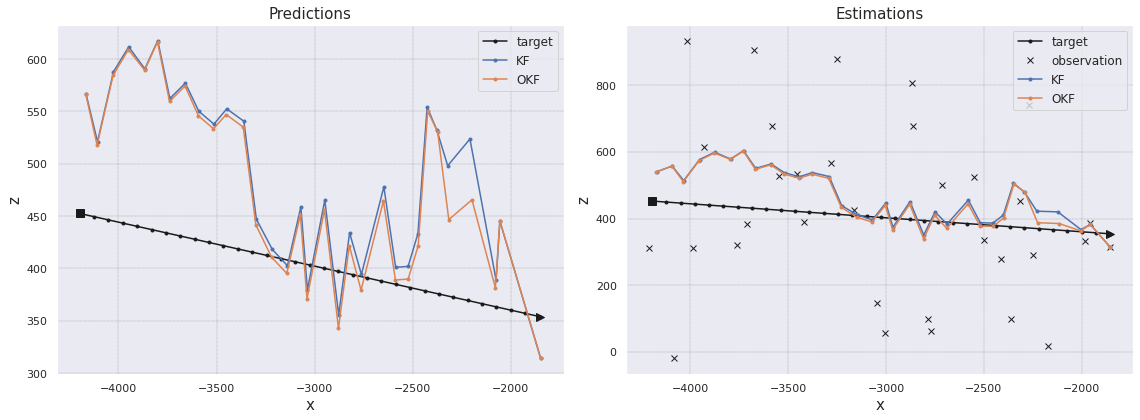

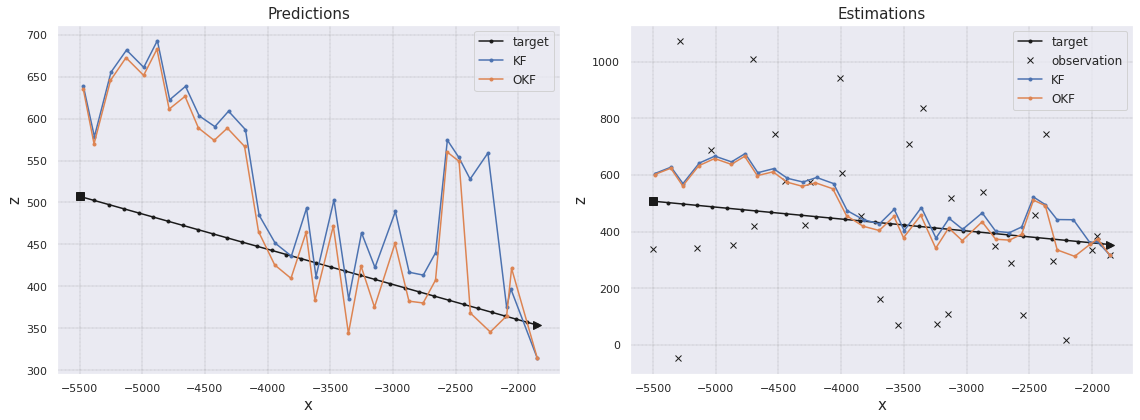

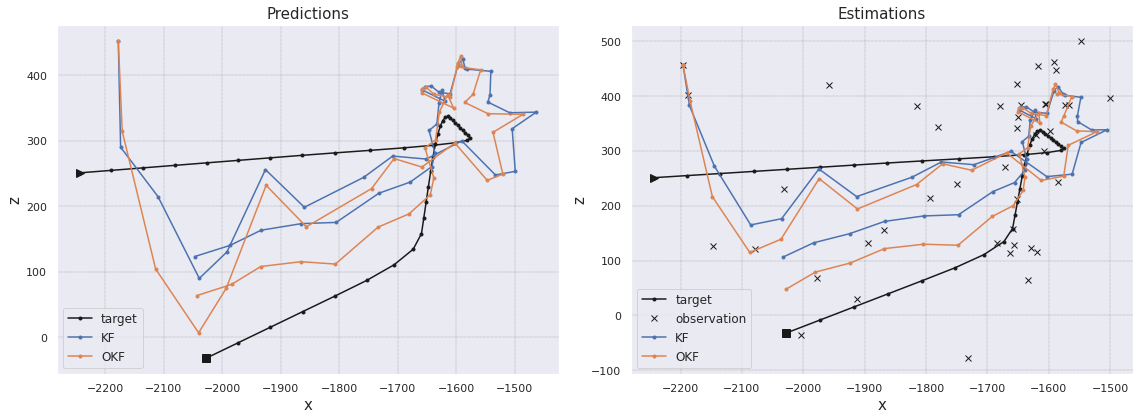

In [22]:
axs = PLAB.multi_scenario_models_plot(scenarios, margs, 1, dimy=2);

#### R & Q in KF vs. OKF

In R, OKF assigns less credit to the doppler signal (the variance of x,y,z is smaller).
Q is quite similar (OKF assigns slightly more credit to position over speed).

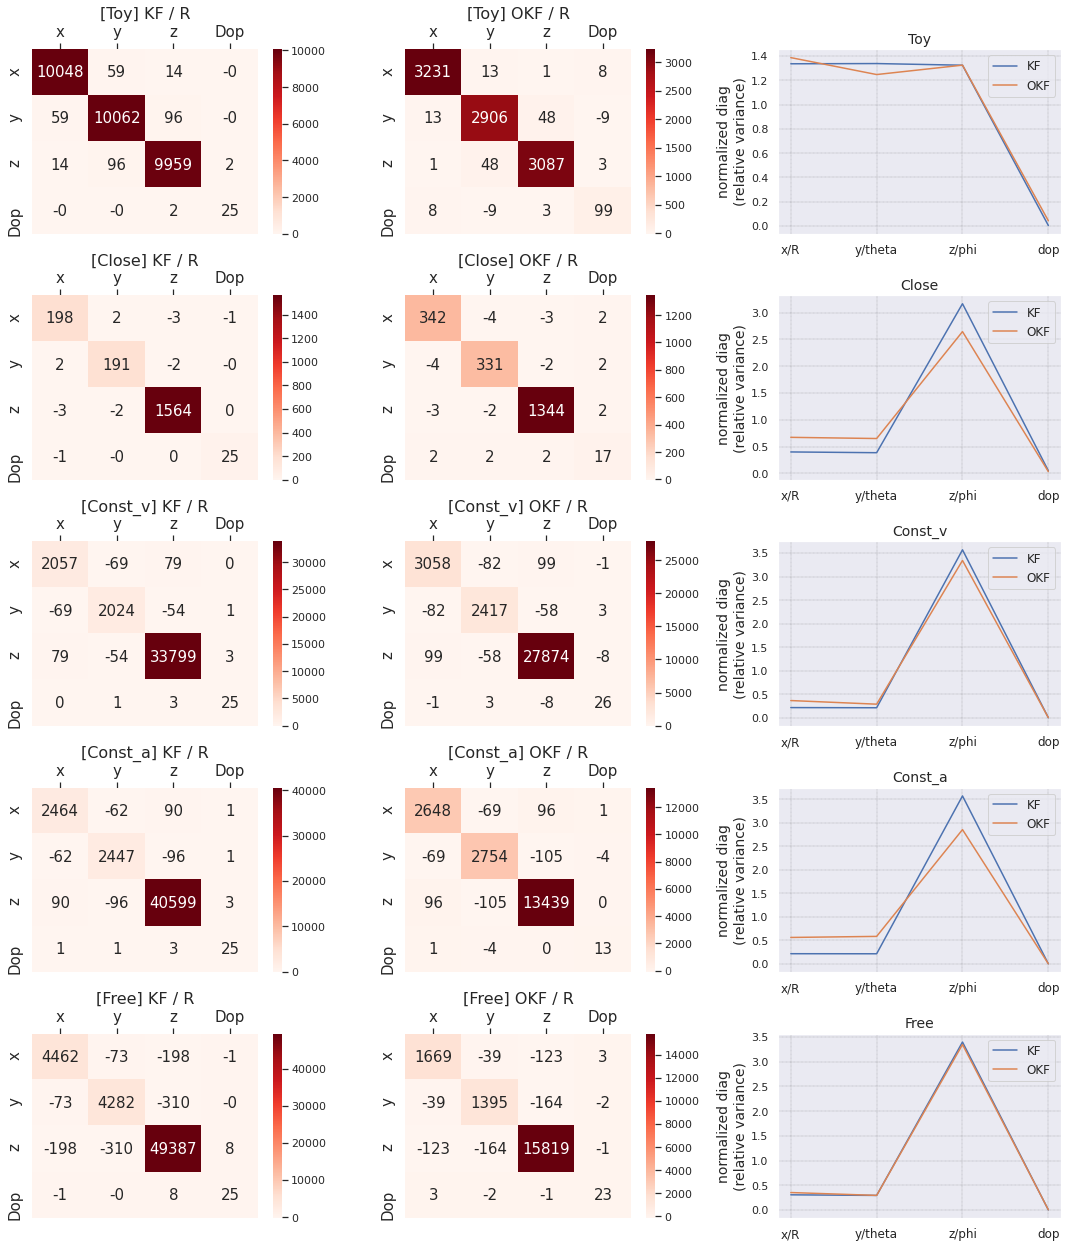

In [23]:
axs = PLAB.compare_noise_models(scenarios, margs, noise='R', fontsize=15);
plt.savefig('outputs/case_study_R.png', bbox_inches='tight')

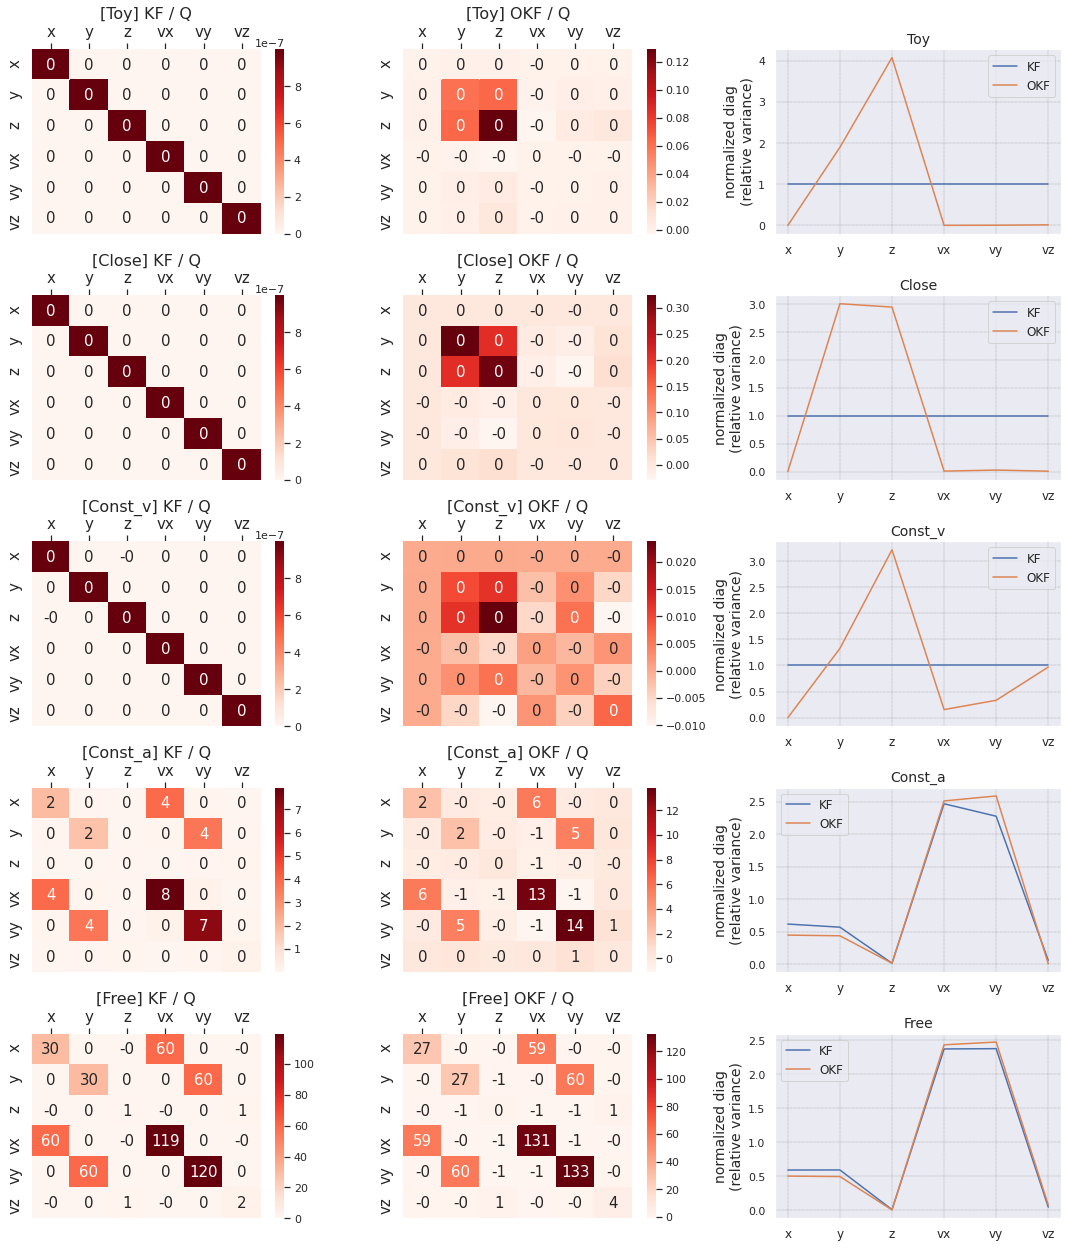

In [24]:
axs = PLAB.compare_noise_models(scenarios, margs, noise='Q', log=False, fontsize=15);
plt.savefig('outputs/case_study_Q.png', bbox_inches='tight')

In [25]:
margs_E = [m for m in models_args if m['title'] in ('EKF','OEKF')]

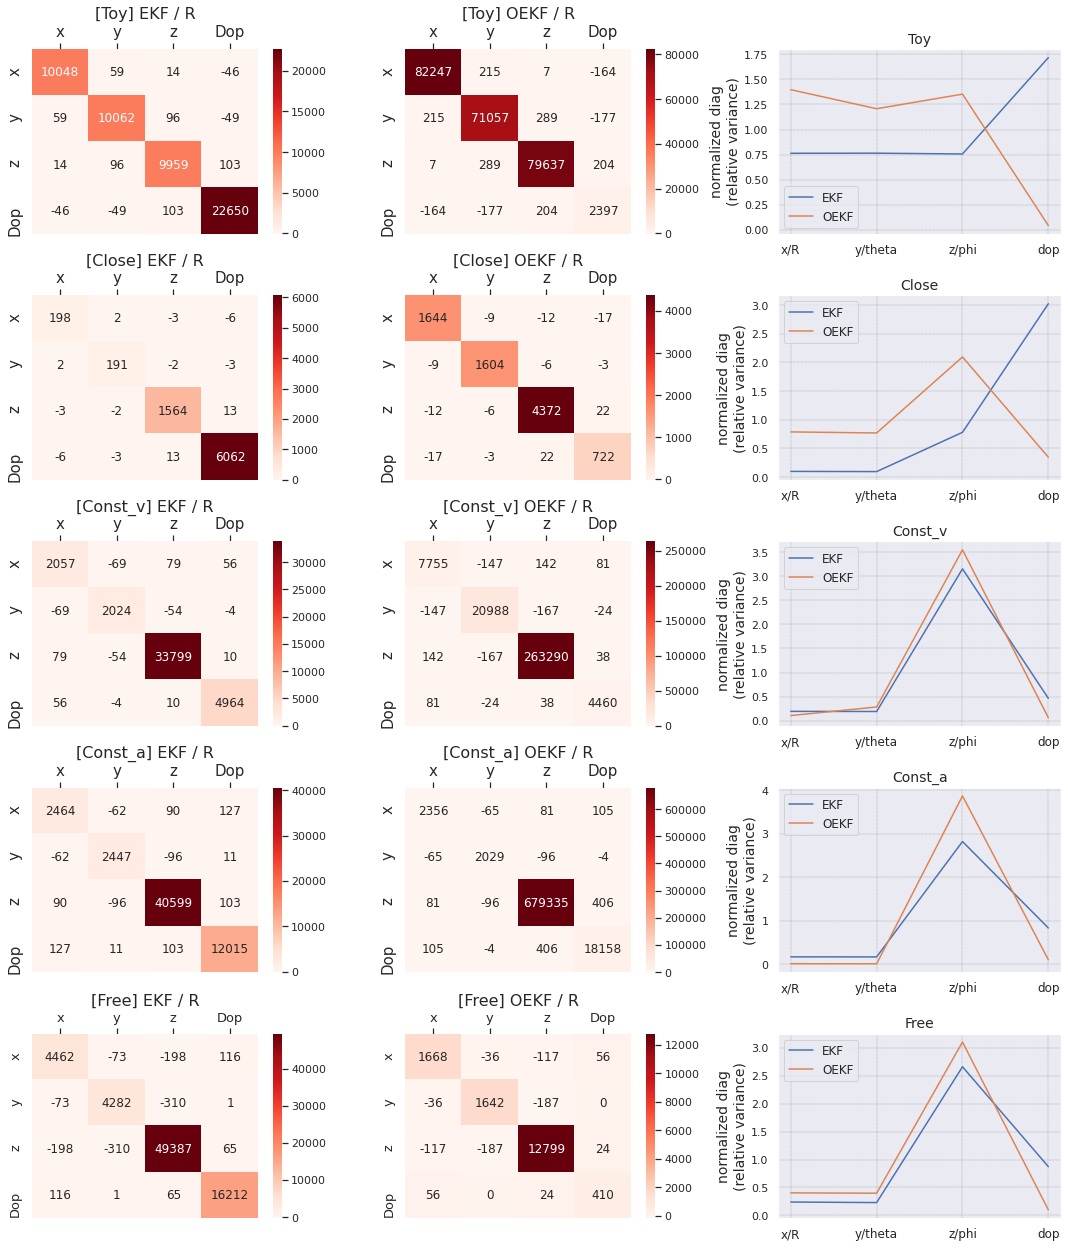

In [26]:
axs = PLAB.compare_noise_models(scenarios, margs_E, noise='R');

axs[-3].set_xticklabels(['x','y','z','Dop'], fontsize=13)
axs[-3].set_yticklabels(['x','y','z','Dop'], fontsize=13)
axs[-2].set_xticklabels(['x','y','z','Dop'], fontsize=13)
axs[-2].set_yticklabels(['x','y','z','Dop'], fontsize=13);

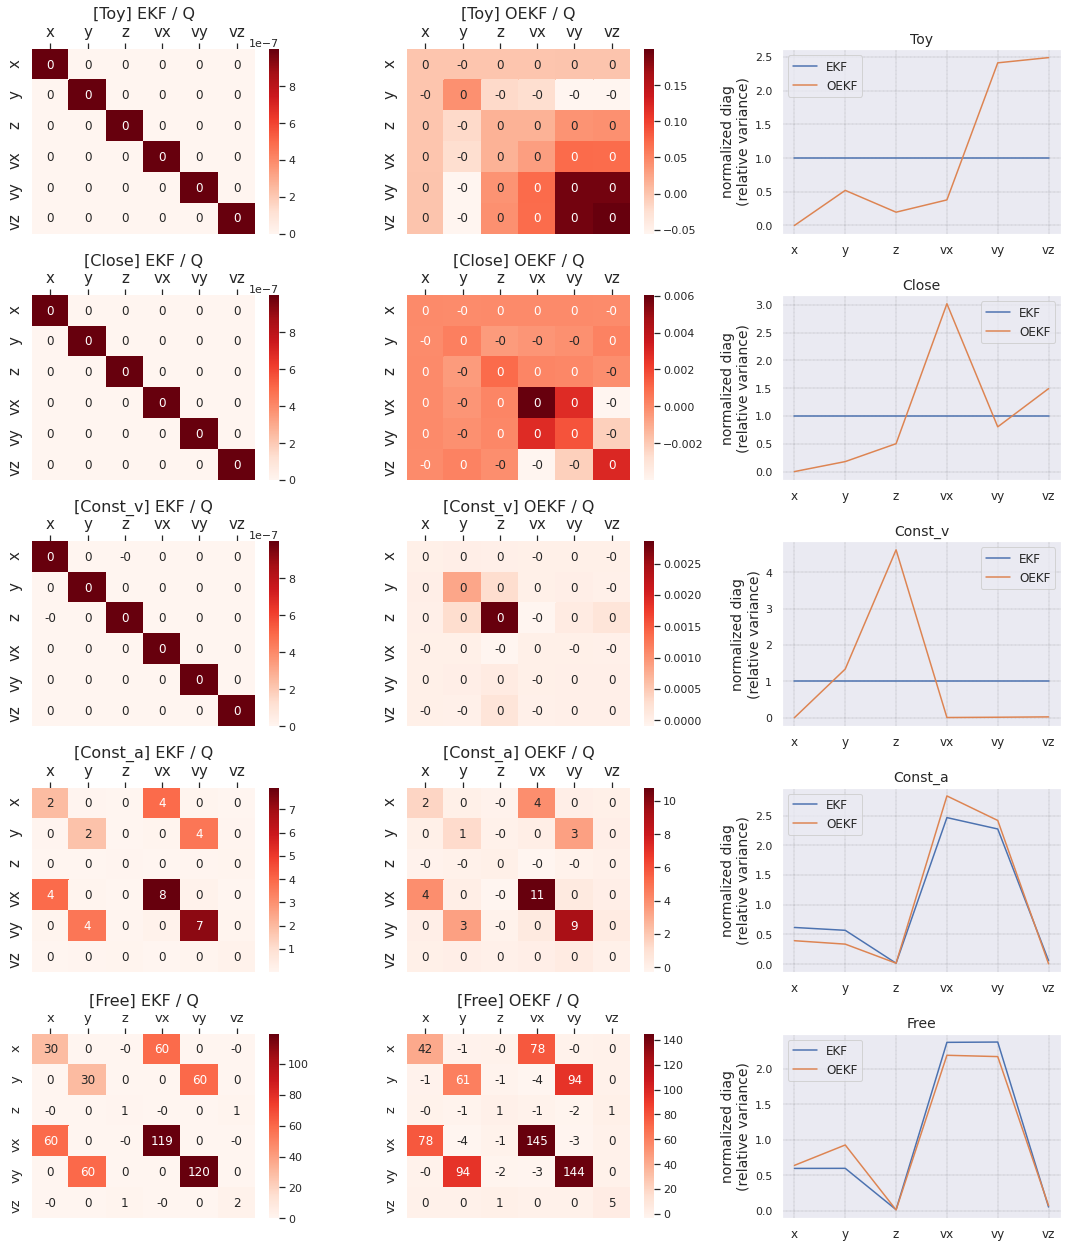

In [27]:
axs = PLAB.compare_noise_models(scenarios, margs_E, noise='Q', log=False)

axs[-3].set_xticklabels(['x','y','z','vx','vy','vz'], fontsize=13)
axs[-3].set_yticklabels(['x','y','z','vx','vy','vz'], fontsize=13)
axs[-2].set_xticklabels(['x','y','z','vx','vy','vz'], fontsize=13)
axs[-2].set_yticklabels(['x','y','z','vx','vy','vz'], fontsize=13);

## Oracle


Close
[KFp_oracle] PHASE I:
1 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(3 [s])

Const_v
[KFp_oracle] PHASE I:
1 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(3 [s])

Const_a
[KFp_oracle] PHASE I:
1 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(3 [s])

Free
[KFp_oracle] PHASE I:
1 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(6 [s])


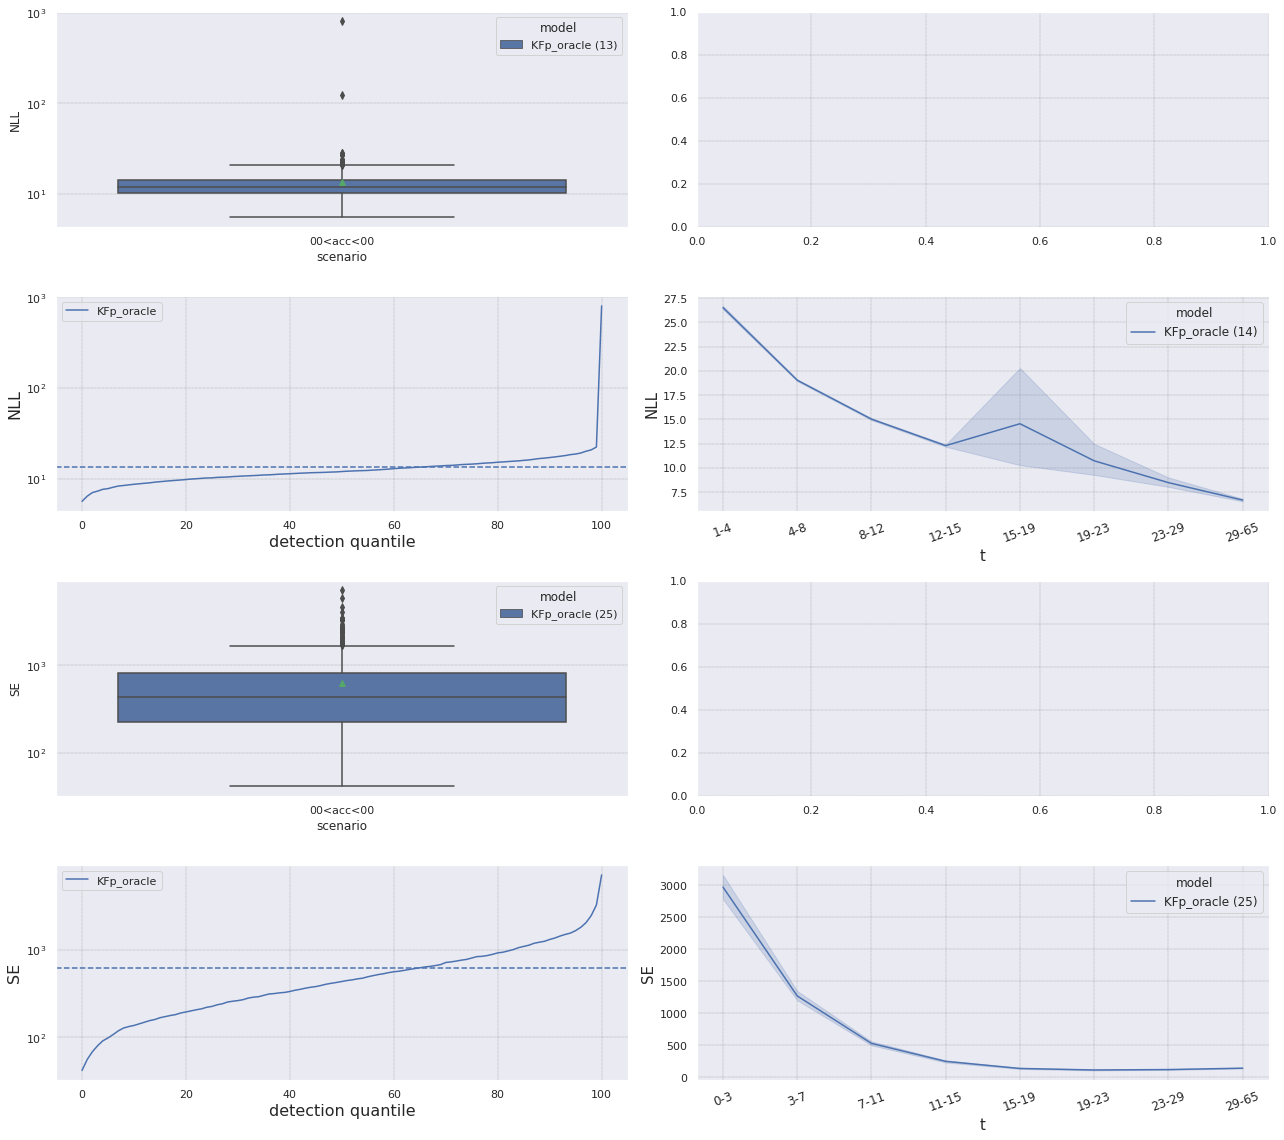

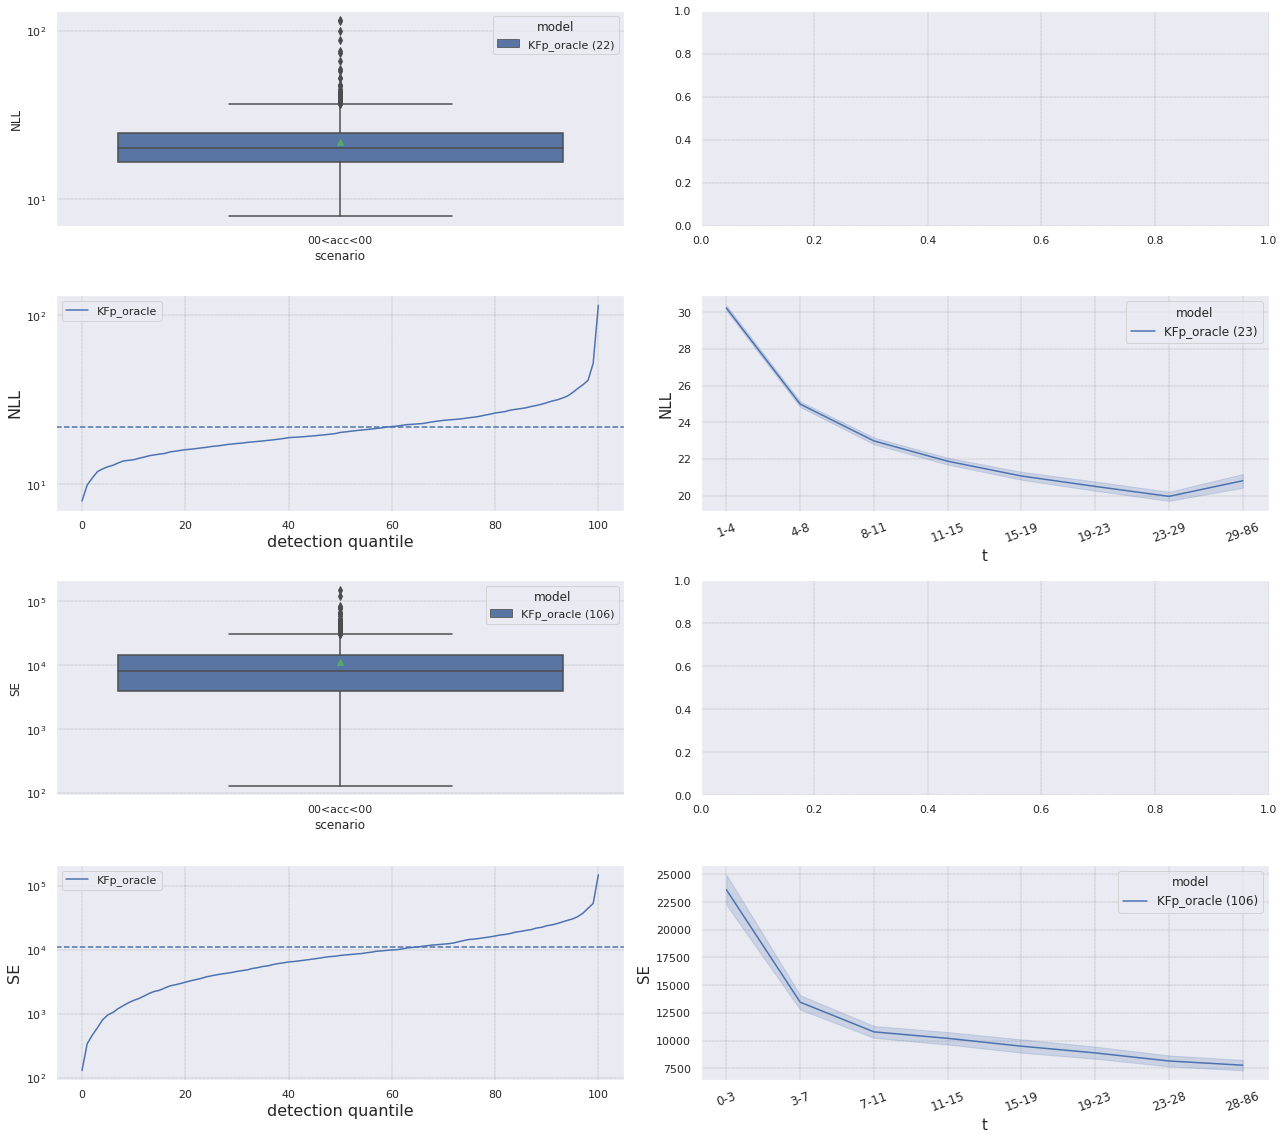

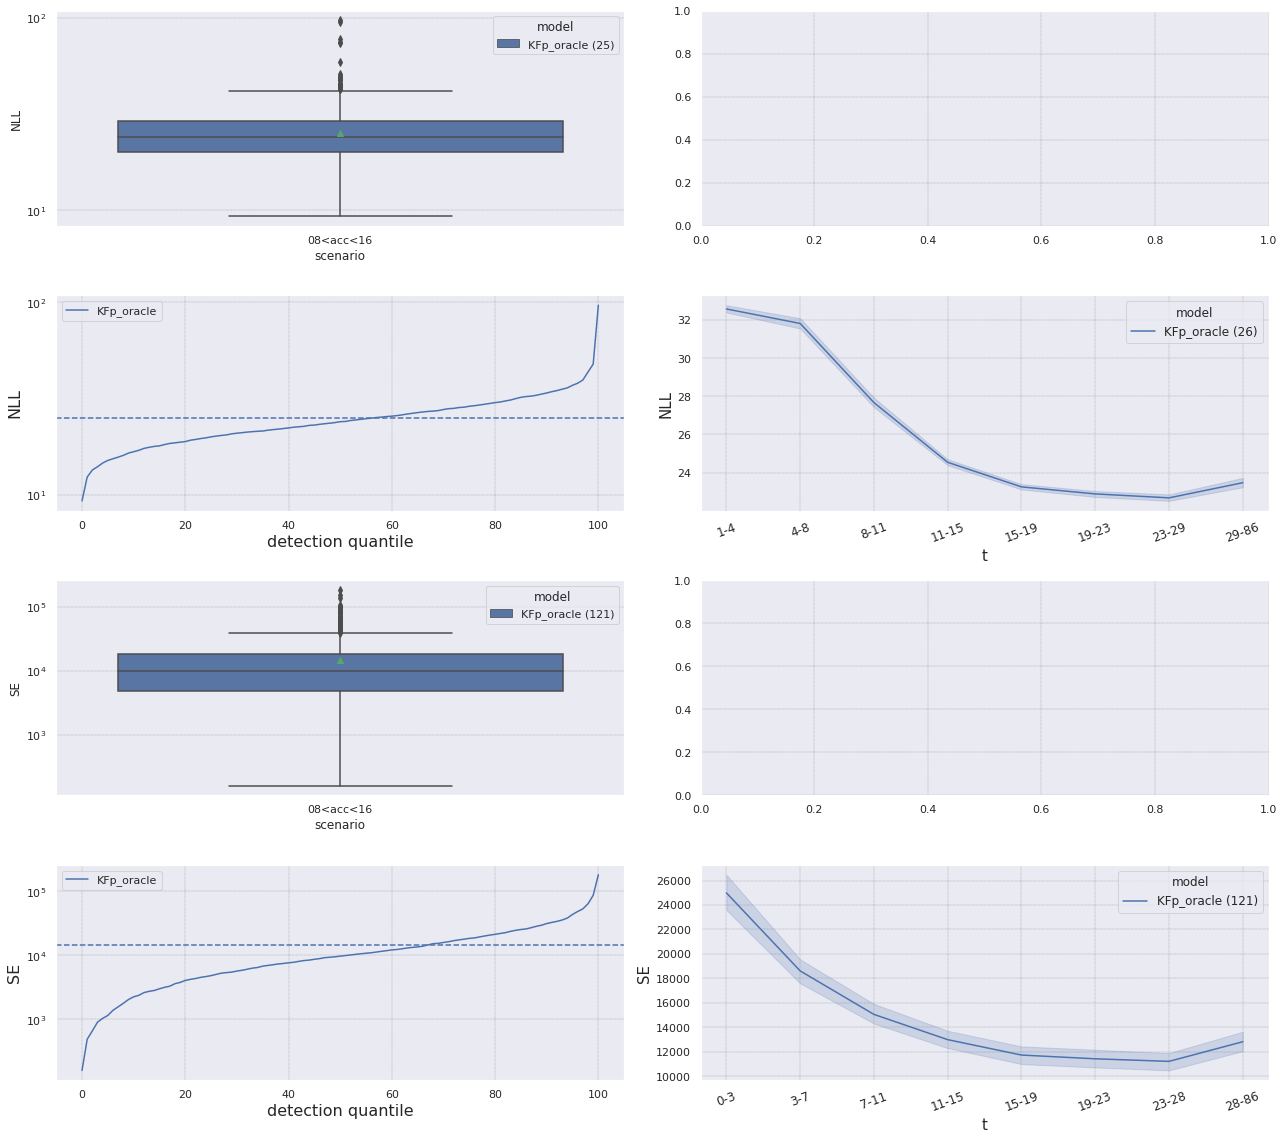

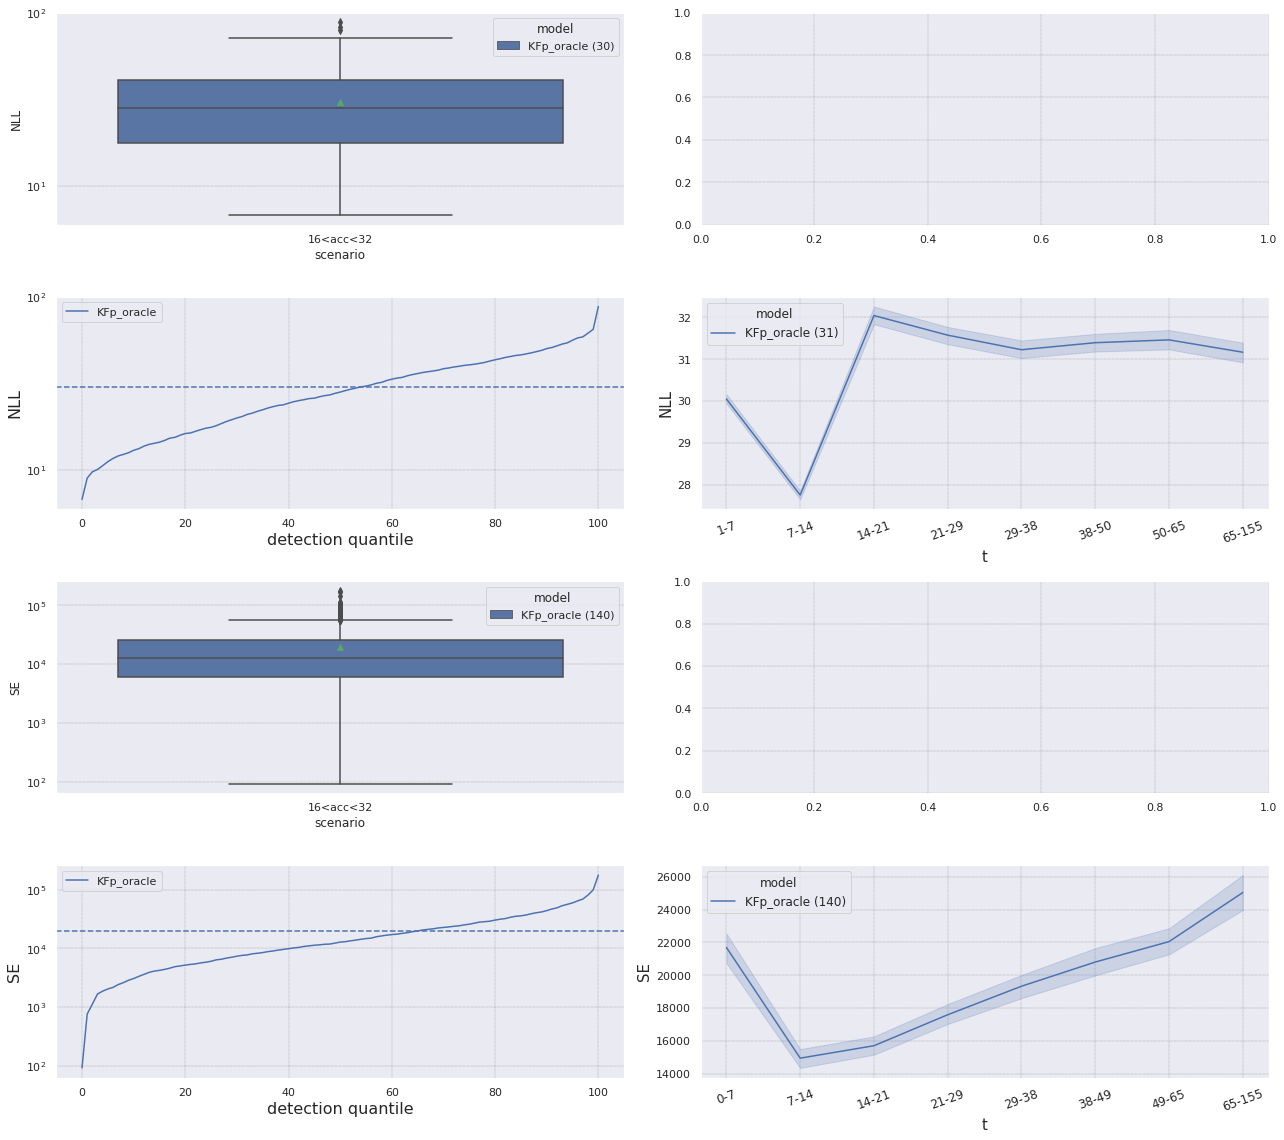

In [28]:
args_or = [dict(load=False, title='KFp_oracle', no_acc=True, polar_R=True, cheat_R=True)]
res_oracle = PLAB.multi_scenario_test(scenarios[1:], args_or, epochs=2)
res_oracle_tar = PLAB.res_per_target(res_oracle, ['model','scenario'])

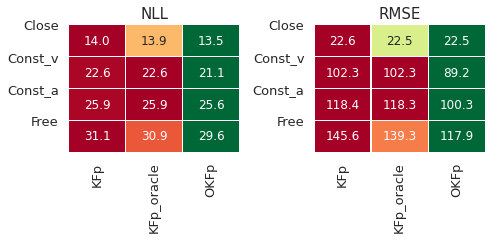

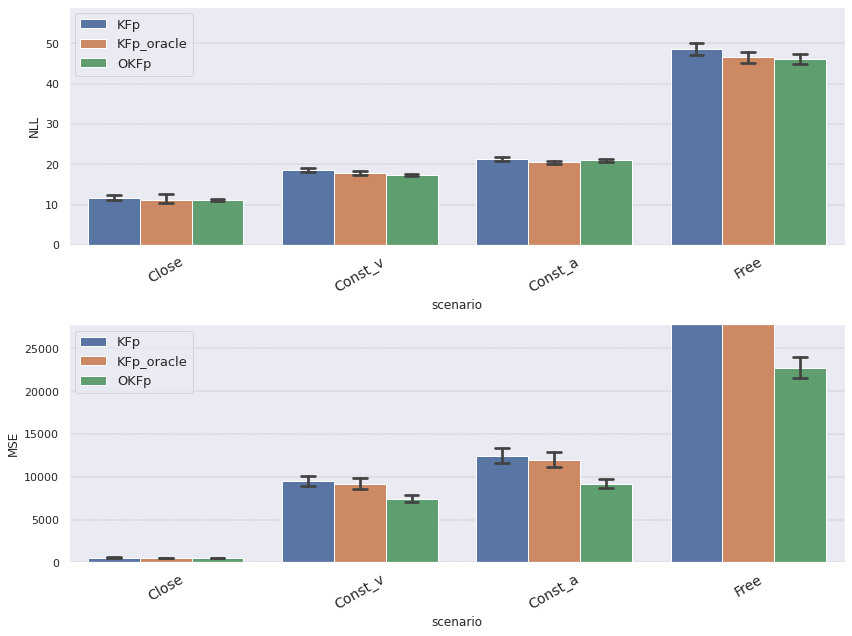

In [29]:
axs = PLAB.multi_scenario_analysis(pd.concat((res,res_oracle)), pd.concat((res_tar,res_oracle_tar)), scenarios=scenarios[1:], models=('KFp','KFp_oracle','OKFp'),
                                   hetro_models=False, axsize=(3.5,3.5), savefig='oracle');

# Optimized $R$ vs. optimized $Q$

In the main benchmark (*multiphase* scenario), it seems that **both optimizations of $R$ and of $Q$ are valuable to the performance**. Optimization of $R$ seems to be more dominant in MSE improvement, and optimization of $Q$ in NLL.

These results were *not* verified widely over different scenarios and initial weights.

In [30]:
models_args = (
    dict(load=False, title='KF', no_acc=True),
    dict(load=False, title='ORKF', no_acc=True, const_R=False),
    dict(load=False, title='OQKF', no_acc=True, const_Q=False),
    dict(load=False, title='OKF', no_acc=True, const_Q=False, const_R=False),
)

model_names = [a['title'] for a in models_args]

gc.collect()

225061


multiphase
Waiting for trainings...
Waiting for processes...
Done.	(231 [s])
Best validation losses:
	KF: inf (KF_s00)
	ORKF: 122 (ORKF_s00)
	OQKF: 124 (OQKF_s00)
	OKF: 121 (OKF_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))


4 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(19 [s])


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


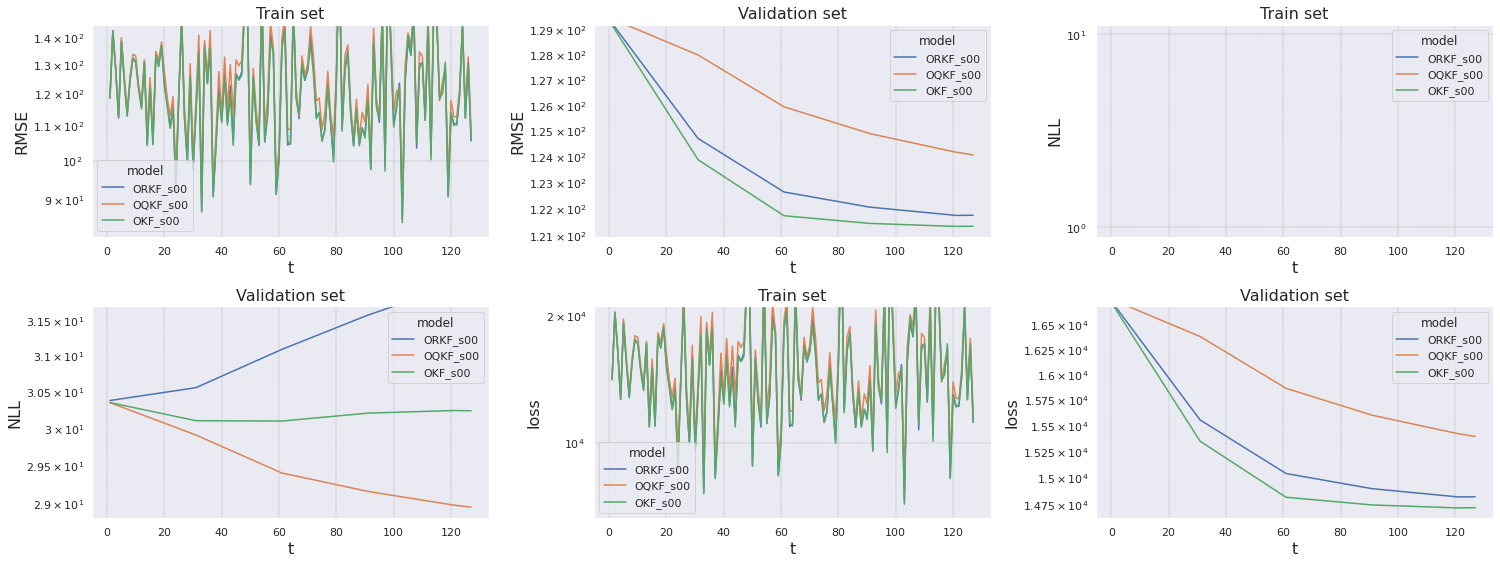

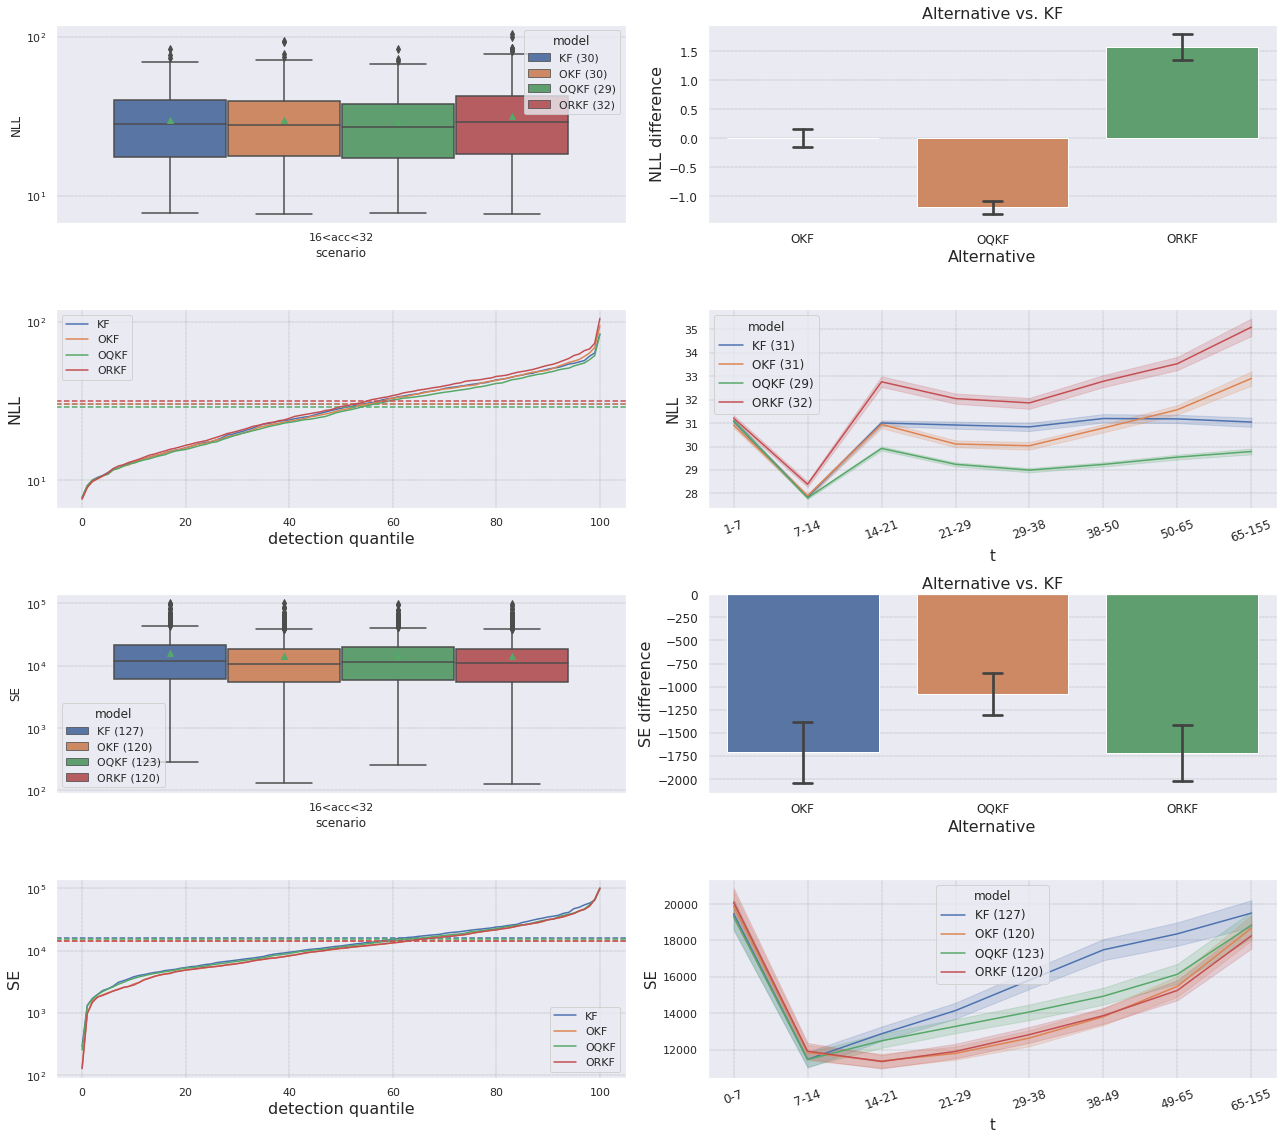

In [31]:
scenario = 'multiphase'
res = PLAB.multi_scenario_test([scenario], models_args)

In [32]:
axs = PLAB.multi_scenario_analysis(res, scenarios=[scenario], models=('KF','ORKF','OQKF','OKF'), hetro_models=False);

# NKF

This section is based on data & models from the `Neural Kalman Filter` notebook.

In [33]:
X2,Y2,scenarios_test = PLAB.load_data(fname=f'test00')

models_args = [
    dict(load=False, title='KFc', no_acc=True),
    dict(load=False, title='KFp', no_acc=True, polar_R=True),
    dict(load=False, title='OKFc', no_acc=True, const_R=False, const_Q=False),
    dict(load=False, title='OKFp', no_acc=True, const_R=False, const_Q=False, polar_R=True),
    dict(load=False, title='NKFc', dynamic_Q='nn', dynamic_R=True),
    dict(load=False, title='NKFp', dynamic_Q='nn', dynamic_R=True, polar_R=True),
]
for a in models_args:
    a['load'] = f'data00_{a["title"]}'
models = [NT.NeuralKF(**a) for a in models_args]

In [34]:
rn = PLAB.test_models(models, X2, Y2, scenarios_test)
rn.to_pickle('data/NKF_results.pkl')

6 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(98 [s])


In [35]:
rn = pd.read_pickle('data/NKF_results.pkl')
rn

model   scenario  target   t  predicted_gaussian  matched_gaussian  \
0        KFc  12<acc<24       0   0                   0                 0   
1        KFc  12<acc<24       0   1                   0                 0   
2        KFc  12<acc<24       0   2                   0                 0   
3        KFc  12<acc<24       0   3                   0                 0   
4        KFc  12<acc<24       0   4                   0                 0   
...      ...        ...     ...  ..                 ...               ...   
805951  NKFp  24<acc<48    1989  54                   0                 0   
805952  NKFp  24<acc<48    1989  55                   0                 0   
805953  NKFp  24<acc<48    1989  56                   0                 0   
805954  NKFp  24<acc<48    1989  57                   0                 0   
805955  NKFp  24<acc<48    1989  58                   0                 0   

              NLL             SE          AE           loss  
0        0.000000    6113.804956   78.190824    6113.804956  
1       35.892436   16288.465706  127.626274   16288.465706  
2       33.362984    3441.101529   58.660903    3441.101529  
3       30.114110   56558.874973  237.821099   56558.874973  
4       29.860264   12538.682759  111.976260   12538.682759  
...           ...            ...         ...            ...  
805951  58.535217   88603.812341  297.663925   88603.812341  
805952  55.411190  154724.467129  393.350311  154724.467129  
805953  76.161589  154778.666953  393.419200  154778.666953  
805954  81.667921  209051.168086  457.221137  209051.168086  
805955  95.552435  161795.299286  402.237864  161795.299286  

[805956 rows x 10 columns]

/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


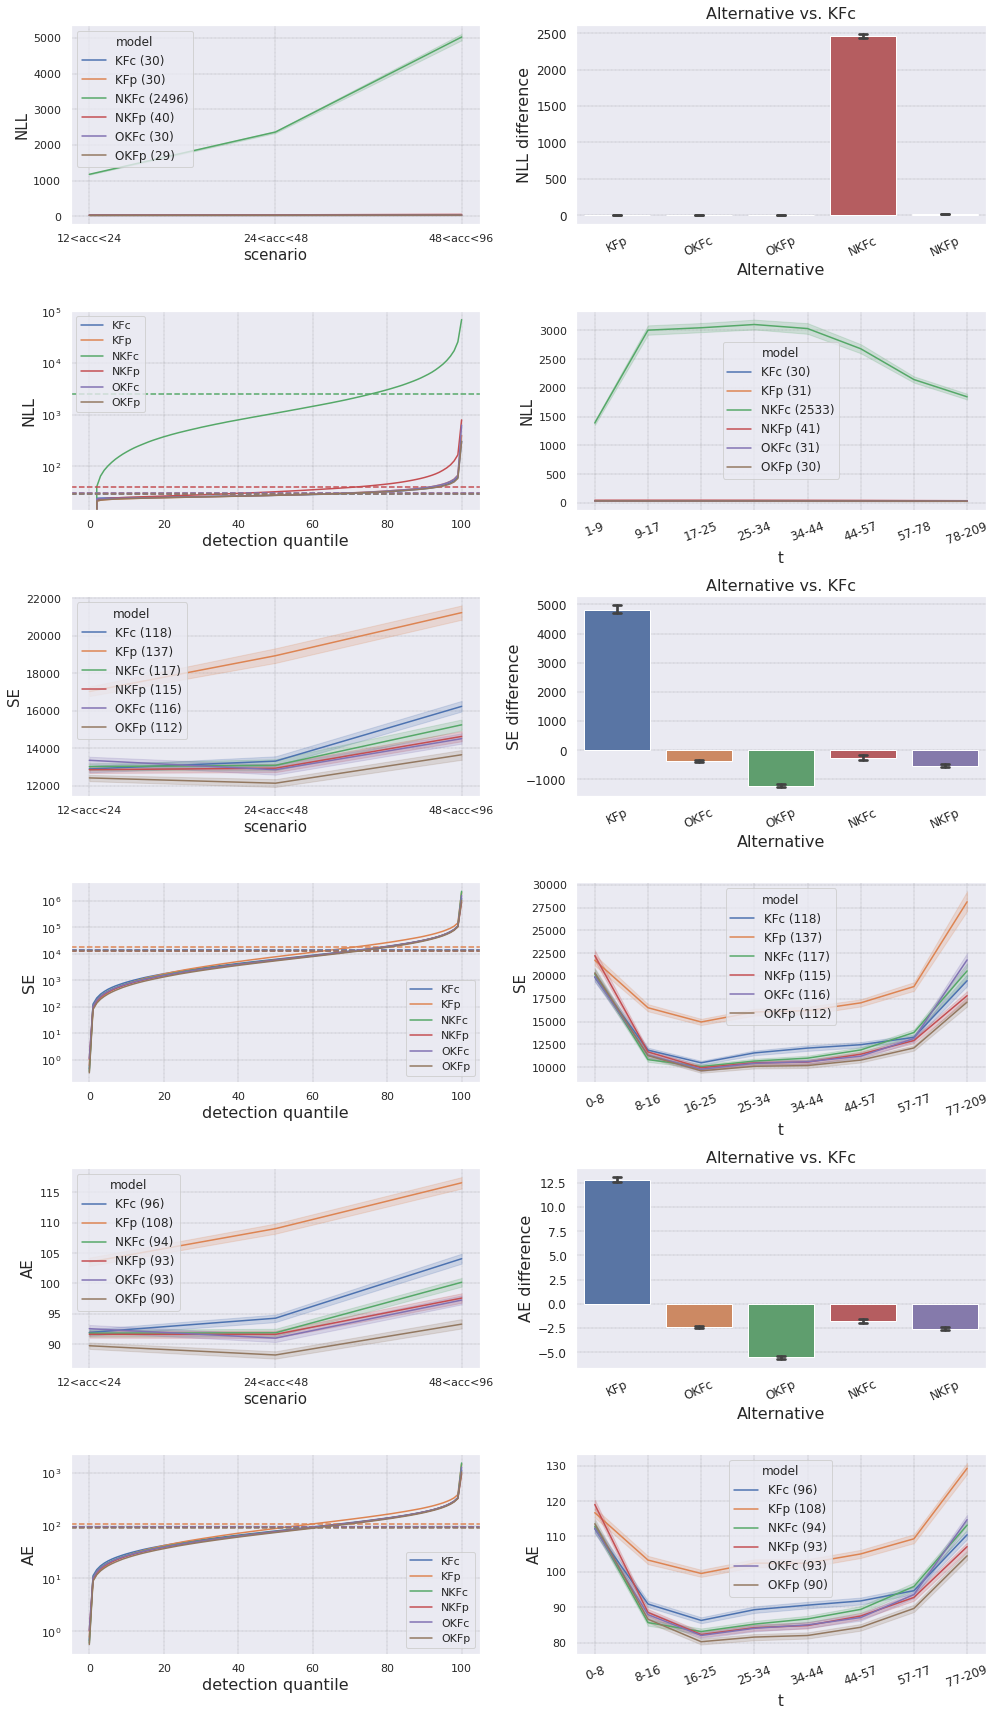

In [36]:
axs = PLAB.test_analysis(rn, axargs=dict(W=2, axsize=(7,4)));

/home/ido/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


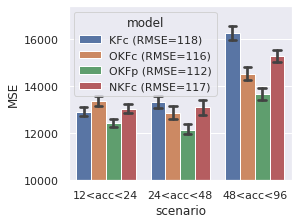

In [37]:
tmp = rn[rn.model.isin(('KFc','NKFc','OKFc','OKFp'))]

plt.figure(figsize=(4,3.2))
for m in np.unique(tmp.model):
    tmp.loc[tmp.model==m, 'model'] = f'{m} (RMSE={np.sqrt(np.mean(tmp.SE[tmp.model==m])):.0f})'
sns.barplot(data=tmp, x='scenario', hue='model', y='SE', capsize=.1)
plt.ylabel('MSE')
plt.ylim((10000,None));
plt.savefig('outputs/NKF_MSE_extended')

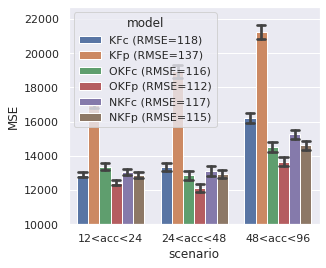

In [38]:
tmp = rn.copy()

plt.figure(figsize=(4.5,4))
for m in np.unique(tmp.model):
    tmp.loc[tmp.model==m, 'model'] = f'{m} (RMSE={np.sqrt(np.mean(tmp.SE[tmp.model==m])):.0f})'
sns.barplot(data=tmp, x='scenario', hue='model', y='SE', capsize=.1)
plt.ylabel('MSE')
plt.ylim((10000,None));
plt.savefig('outputs/NKF_MSE_extended2')

**For each of KF,OKF,NKF - choose the better variant (either Cartesian or polar):**

(the choice relies on the *validation* data as provided in the training process in "Neural Kalman Filter.ipynb")

In [50]:
rn2 = rn[rn.model.isin(('KFc','NKFp','OKFp'))].copy()
rn2['model'] = [m[:-1] for m in rn2.model]

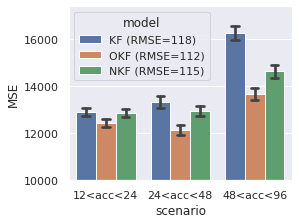

In [51]:
tmp = rn2.copy()

plt.figure(figsize=(4,3.2))
for m in np.unique(tmp.model):
    tmp.loc[tmp.model==m, 'model'] = f'{m} (RMSE={np.sqrt(np.mean(tmp.SE[tmp.model==m])):.0f})'
sns.barplot(data=tmp, x='scenario', hue='model', y='SE', capsize=.1, ci=95)
plt.ylabel('MSE')
plt.ylim((10000,None));
plt.savefig('outputs/NKF_MSE.png')

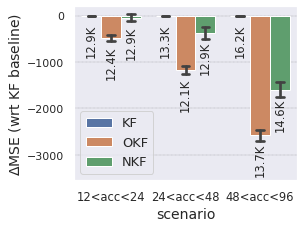

In [53]:
tmp = rn2.copy()
m0 = 'KF'
ref = tmp.SE[tmp.model==m0].values
for m in np.unique(tmp.model):
    tmp.loc[tmp.model==m,'SE'] = tmp.SE[tmp.model==m].values - ref

ax = utils.Axes(1,1,axsize=(4,3.2))[0]

h = sns.barplot(data=tmp, x='scenario', hue='model', y='SE', capsize=.1, ci=95)
for i,(p,s) in enumerate(zip(h.patches, len(np.unique(rn2.model))*list(np.unique(rn2.scenario)))):
    mse = p.get_height() + rn2.SE[(rn2.model==m0)&(rn2.scenario==s)].mean()
    h.annotate(f'{mse/1000:.1f}K',
               (p.get_x() + p.get_width() / 2., p.get_height()), rotation=90,
               ha = 'center', va = 'top',  size=11.5, xytext = (0, -8),  textcoords = 'offset points')
ax.set_ylim((-3550,200))
utils.labels(ax, 'scenario', '$\Delta$MSE (wrt KF baseline)', fontsize=14)
ax.legend(fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11.5);

plt.savefig('outputs/NKF_MSE_paired.png', bbox_inches='tight')

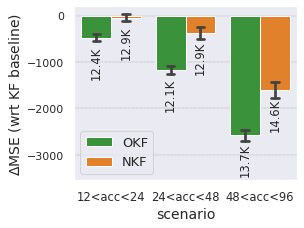

In [54]:
tmp = rn2.copy()
m0 = 'KF'
ref = tmp.SE[tmp.model==m0].values
for m in np.unique(tmp.model):
    tmp.loc[tmp.model==m,'SE'] = tmp.SE[tmp.model==m].values - ref

ax = utils.Axes(1,1,axsize=(4,3.2))[0]

colors = sns.color_palette("tab10")[1:3]
tmp = tmp[tmp.model!='KF']
nms = np.unique(tmp.model)
h = sns.barplot(data=tmp, x='scenario', hue='model', y='SE', capsize=.1, ci=95, palette={nms[0]:colors[0],nms[1]:colors[1]})
for i,(p,s) in enumerate(zip(h.patches, len(np.unique(rn2.model))*list(np.unique(rn2.scenario)))):
    mse = p.get_height() + rn2.SE[(rn2.model==m0)&(rn2.scenario==s)].mean()
    h.annotate(f'{mse/1000:.1f}K',
               (p.get_x() + p.get_width() / 2., p.get_height()), rotation=90,
               ha = 'center', va = 'top',  size=11.5, xytext = (0, -8),  textcoords = 'offset points')
ax.set_ylim((-3550,200))
utils.labels(ax, 'scenario', '$\Delta$MSE (wrt KF baseline)', fontsize=14)
ax.legend(fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11.5);

plt.savefig('outputs/NKF_MSE_paired_clean.png', bbox_inches='tight')

41


model
KFc      9151.847689
KFp     12085.370939
NKFc     7432.426797
NKFp     8655.889514
OKFc     8340.800705
OKFp     8260.861146
dtype: float64

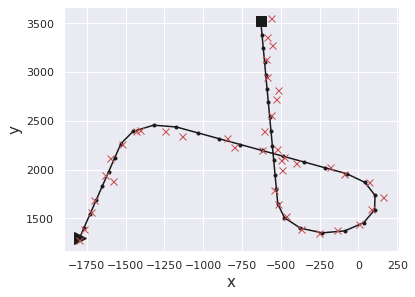

In [45]:
i = 13
plt.figure(figsize=(6,4.5))

xx = Y2[i][:,0]
xy = Y2[i][:,1]
xz = Y2[i][:,2]
zx = X2[i][:,0]
zy = X2[i][:,1]
zz = X2[i][:,2]
plt.plot([xx[0]],[xy[0]],'k>',markersize=12)
plt.plot([xx[-1]],[xy[-1]],'ks',markersize=10)
plt.plot(xx,xy,'k.-')
plt.plot(zx,zy,'rx', markersize=7)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)

print(len(xx))
rn[rn.target==i].groupby('model').apply(lambda d: d.SE.mean())

In [46]:
def get_track(model, Z):
    x = []
    model.init_state()
    for t in range(len(Z)):
        model.predict()
        model.do_update(Z[t,:])
        x.append(model.get_pos())
    return x

In [47]:
tracks = []
for m in models:
    if m.title in ('KFc','NKFc','OKFp'):
        tracks.append(get_track(m, X2[i]))

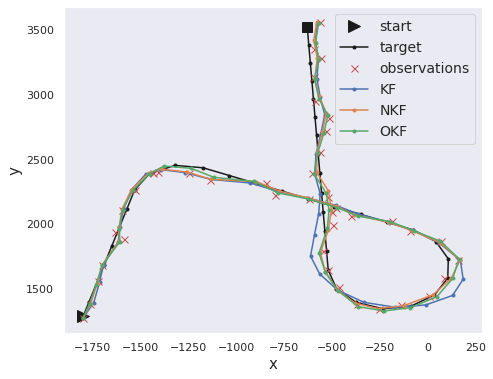

In [48]:
plt.figure(figsize=(7.5,6))
plt.grid()

plt.plot([xx[0]],[xy[0]],'k>',markersize=12, label='start')
plt.plot([xx[-1]],[xy[-1]],'ks',markersize=10)
plt.plot(xx,xy,'k.-', label='target')
plt.plot(zx,zy,'rx', markersize=7, label='observations')

plt.plot([x[0] for x in tracks[0]], [x[1] for x in tracks[0]], '.-', label='KF')
plt.plot([x[0] for x in tracks[1]], [x[1] for x in tracks[1]], '.-', label='NKF')
plt.plot([x[0] for x in tracks[2]], [x[1] for x in tracks[2]], '.-', label='OKF')

plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=14);
plt.savefig('outputs/res_sample.png')

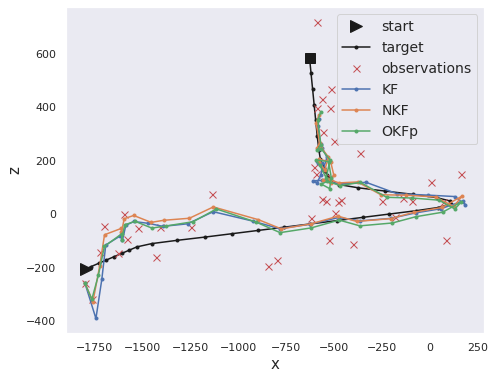

In [49]:
plt.figure(figsize=(7.5,6))
plt.grid()

plt.plot([xx[0]],[xz[0]],'k>',markersize=12, label='start')
plt.plot([xx[-1]],[xz[-1]],'ks',markersize=10)
plt.plot(xx,xz,'k.-', label='target')
plt.plot(zx,zz,'rx', markersize=7, label='observations')

plt.plot([x[0] for x in tracks[0]], [x[2] for x in tracks[0]], '.-', label='KF')
plt.plot([x[0] for x in tracks[1]], [x[2] for x in tracks[1]], '.-', label='NKF')
plt.plot([x[0] for x in tracks[2]], [x[2] for x in tracks[2]], '.-', label='OKFp')

plt.xlabel('x', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.legend(fontsize=14);